<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/output-spikes/Entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset -f

In [ ]:
!pip install torch

In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 18.1 MB/s eta 0:00:00


In [ ]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
!pip install torchsummary

In [ ]:
!pip install torch

## set seeds for PyTorch and Numpy to ensure reproducibility:

In [ ]:
import torch
import random
import numpy as np

# Set seeds for Python, Numpy, and Torch for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Additional steps if you're using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
# imports
import pickle
import matplotlib.animation as animation
from scipy.integrate import simps
import torch
torch.cuda.empty_cache()
import os, sys, time, datetime, json, random
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils as utls
from snntorch import utils
from snntorch import surrogate
import numpy as np
import math
from sklearn.metrics import auc
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.nn as nn
from scipy.stats import entropy
from scipy.special import kl_div
from torch.autograd import Variable
import torch
import seaborn as sns
from scipy.stats import bernoulli
import pandas as pd
# import spikeflow as snn

In [ ]:
# /////////////////////# Building the Autoencoder
#-------------------DataLoaders.  using the MNIST dataset

# dataloader arguments
batch_size = 250
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# /////////////////////////////////# Define a transform
input_size = 32 # resizing the original MNIST from 28 to 32

transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

#------------------------------------------- Load MNIST
# Training data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing data
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 228535917.83it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 106821599.49it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 76794601.16it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 10948579.75it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
# creating directories where we can save the original and reconstructed images for training and testing:
# create training/ and testing/ folders in the chosen path
if not os.path.isdir('figures/training'):
    os.makedirs('figures/training')
if not os.path.isdir('figures/binarytraining'):
    os.makedirs('figures/binarytraining')

if not os.path.isdir('figures/testing'):
    os.makedirs('figures/testing')
if not os.path.isdir('figures/binarytesting'):
    os.makedirs('figures/binarytesting')


if not os.path.isdir('Saved_Trained_Checkpoints/'):
    os.makedirs('Saved_Trained_Checkpoints/')

if not os.path.isdir('Output_Spikes/'):
    os.makedirs('Output_Spikes/')

if not os.path.isdir('Enc_syn_Spikes/'):
    os.makedirs('Enc_syn_Spikes/')


if not os.path.isdir('Intermediate_Lyrs/'):
    os.makedirs('Intermediate_Lyrs/')



In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name()} ({device})")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using Tesla T4 (cuda)


In [ ]:
# class SAE(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # Encoder
#         self.encoder = nn.Sequential(
#                             nn.Conv2d(1, 32, 3,padding = 1,stride=2), # Conv Layer 1
#                             nn.BatchNorm2d(32),
#                             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             nn.Conv2d(32, 64, 3,padding = 1,stride=2), # Conv Layer 2
#                             nn.BatchNorm2d(64),
#                             snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, threshold=thresh), #SNN TORCH LIF NEURON
#                             nn.Conv2d(64, 128, 3,padding = 1,stride=2), # Conv Layer 3
#                             nn.BatchNorm2d(128),
#                             snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
#                             nn.Flatten(start_dim = 1, end_dim = 3), #Flatten convolutional output
#                             nn.Linear(128*4*4, latent_dim), # Fully connected linear layer
#                             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
#                             )


#         self.latent_dim = latent_dim #dimensions of the encoded z-space data
#         self.linearNet= nn.Sequential(
#                                       nn.Linear(latent_dim,128*4*4),
#                                       snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))

#         # Decoder:
#         self.decoder = nn.Sequential(
#                             nn.Unflatten(1,(128,4,4)), #Unflatten data from 1 dim to tensor of 128 x 4 x 4
#                             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             nn.ConvTranspose2d(128, 64, 3,padding = 1,stride=(2,2),output_padding=1),
#                             nn.BatchNorm2d(64),
#                             snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             nn.ConvTranspose2d(64, 32, 3,padding = 1,stride=(2,2),output_padding=1),
#                             nn.BatchNorm2d(32),
#                             snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
#                             nn.ConvTranspose2d(32, 1, 3,padding = 1,stride=(2,2),output_padding=1),
#                             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
#                             )
#     def forward(self, x):
#         utils.reset(self.encoder) #need to reset the hidden states of LIF
#         utils.reset(self.decoder)
#         utils.reset(self.linearNet)

#     #-----------------------------encode
#         spk_mem=[];
#         spk_rec=[];
#         spk_rec_syn=[];
#         encoder_mem=[];
#         spk_rec_dec=[];
#         spk_mem_dec=[];
#         enc5_rec = [];


#      #------------------------------ intermediate layers

#         # for step in range(num_steps):
#         #     enc5 = self.encoder[5](x)             #  enc5 shape: torch.Size([250, 1, 32, 32])
#         #     enc5_rec.append(enc5)
#         # enc5_rec = torch.stack(enc5_rec, dim=2)            #   enc5_rec size: torch.Size([250, 1, 5, 32, 32])
#         # Enc_syn_1 = enc5_rec[:, :, -1]                      # #   torch.Size([250, 1, 32, 32])

#      #------------------------------ encode
#         for step in range(num_steps):
#             spk_x, mem_x = self.encoder(x)              # spk_x size: ([250, 32])  ,   mem_x size: ([250, 32])  , x.shape : torch.Size([250, 1, 32, 32])
#             spk_rec.append(spk_x)
#             spk_mem.append(mem_x)

#         spk_rec=torch.stack(spk_rec,dim=2) # stack spikes in second tensor dimension # ----------------spk_rec in torch.stack(spk_rec,dim=2):  torch.Size([250, 32, 5])
#         spk_mem=torch.stack(spk_mem,dim=2) # stack membranes in second tensor dimension # ----------------spk_mem in torch.stack(spk_mem,dim=2):  torch.Size([250, 32, 5])
#         out_en = spk_rec[...,step]

#         # print("out_en= spk_rec[...,step]:-----------" , spk_rec[...,step].size()) # spk_rec[...,step]:----------- torch.Size([250, 32])       input of the latent and then decoder

#      #------------------------------decode
#         spk_mem2=[];
#         spk_rec2=[];
#         decoded_x=[];
#         spk_x_dec=[];
#         mem_x_dec=[];
#         for step in range(num_steps): #for t in time                           #        from decoder: ([250, 1, 32, 32])
#             x_recon, x_mem_recon = self.decode(spk_rec[...,step])
#             spk_rec2.append(x_recon)
#             spk_mem2.append(x_mem_recon)

#         spk_rec2=torch.stack(spk_rec2,dim=4)
#         spk_mem2=torch.stack(spk_mem2,dim=4)

#         out = spk_mem2[:,:,:,:,-1]

#         self.out_en = out_en
#         self.out = out

#         return out, out_en
#         # return out, Enc_syn_1

#     def encode(self,x):
#       spk_latent_x, mem_latent_x = self.encoder(x)
#       return spk_latent_x, mem_latent_x


#     def decode(self,x):
#         spk_x, mem_x = self.linearNet(x) #convert latent dimension back to total size of features in encoder final layer
#         spk_x2, mem_x2 = self.decoder(spk_x)
#         return spk_x2, mem_x2



In [ ]:
# import os
# import shutil

# start_time = datetime.datetime.now()

# # Defining some parameters, and run training and testing
# # batch_size = 250
# input_size = 32 #resize of mnist data (optional)

# #setup GPU
# dtype = torch.float
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# # neuron and simulation parameters
# spike_grad = surrogate.atan(alpha=2.0)  # alternate surrogate gradient fast_sigmoid(slope=25)

# # //////////////////////////////////range for beta////////////////////////
# train_loss_rec = []
# test_loss_rec = []
# train_loss_record = []
# test_loss_record = []
# train_avg_loss_rec=[]
# test_avg_loss_rec=[]


#   #Define Network and optimizer
# net=SAE()
# net = net.to(device)

# optimizer = torch.optim.AdamW(net.parameters(),
#                             lr=0.0001,
#                             betas=(0.9, 0.999),
#                             weight_decay=0.001)


# def clear_figures_directory():
#     if os.path.exists("saved_images"):
#         shutil.rmtree("saved_images")
# # Call the function to clear the "figures" directory before starting the training loop
# clear_figures_directory()





# import torch
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.gridspec import GridSpec
# from torchvision.utils import make_grid
# import os


# alpha=0.9
# beta =0.9
# beta_syn=0.0001
# num_steps=5
# latent_dim = 32 #dimension of latent layer (how compressed we want the information)
# thresh=1    #spiking threshold (lower = more spikes are let through)
# epochs=50
# max_epoch=epochs


# # Create an instance of the SAE class and move it to the GPU
# trained_net = SAE()
# trained_net_e = SAE()
# trained_net = trained_net.to(device)  # Move the model to the GPU
# trained_net_e = trained_net_e.to(device)  # Move the model to the GPU

# trained_net_n = SAE()
# trained_net_e_n = SAE()
# trained_net_n = trained_net_n.to(device)  # Move the model to the GPU
# trained_net_e_n = trained_net_e_n.to(device)  # Move the model to the GPU


# # Load the trained model state dictionary (Make sure to adjust the path to your saved model)

# model_path = "/content/Saved_Trained_Checkpoints/model_epoch_50.pt"
# model_path_e = "/content/Saved_Trained_Checkpoints/model_epoch_50_0.0001.pt"
# model_path_n = "/content/Saved_Trained_Checkpoints/noise_model_epoch_50_StdDev_0.1.pt"
# model_path_e_n = "/content/Saved_Trained_Checkpoints/noise_model_epoch_50_0.0001_StdDev_0.1.pt"


# # Load the trained model state dictionary on the CPU
# state_dict = torch.load(model_path, map_location=torch.device('cpu'))
# state_dict_e = torch.load(model_path_e, map_location=torch.device('cpu'))
# state_dict_n = torch.load(model_path_n, map_location=torch.device('cpu'))
# state_dict_e_n = torch.load(model_path_e_n, map_location=torch.device('cpu'))



# # Load the state dictionary into the model instance
# trained_net.load_state_dict(state_dict)
# trained_net_e.load_state_dict(state_dict_e)
# trained_net_n.load_state_dict(state_dict_n)
# trained_net_e_n.load_state_dict(state_dict_e_n)



# # Move the model to the appropriate device (CPU or GPU)
# trained_net = trained_net.to(device)
# trained_net_e = trained_net_e.to(device)
# trained_net_n = trained_net_n.to(device)
# trained_net_e_n = trained_net_e_n.to(device)

# # Set the model to evaluation mode
# trained_net.eval()
# trained_net_e.eval()
# trained_net_n.eval()
# trained_net_e_n.eval()


# # # Testing data
# # test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
# # test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# # # Assuming you have the trained model and loaded it in the "net" variable as shown in your previous code.
# # # Get one batch from the test_loader
# for batch in test_loader:
#     real_img, _ = batch  # Assuming the test loader returns (data, labels) tuple, and we only need "data"
#     break  # Break after getting the first batch

# for batch in test_loader:
#     real_img, ground_truth_labels = batch  # Assuming the test loader returns (data, labels) tuple
#     real_img = real_img.to(device)
#     ground_truth_labels = ground_truth_labels.to(device)
#     break  # Break after getting the first batch

# real_img = real_img.to(device)


# # First Reconstructed Image with beta_syn=0.9
# with torch.no_grad():
#     reconstructed_images_beta_syn_0_9, out_beta_syn_0_9 = trained_net(real_img)  # Pass beta_syn argument
#     reconstructed_images_beta_syn_0_0001, out_beta_syn_0_0001 = trained_net_e(real_img)  # Pass beta_syn argument

#     noisy_reconstructed_images_beta_syn_0_9, out_beta_syn_0_9_n = trained_net_n(real_img)  # Pass beta_syn argument
#     noisy_reconstructed_images_beta_syn_0_0001, out_beta_syn_0_0001_n = trained_net_e_n(real_img)  # Pass beta_syn argument

# # //////////////////////////////////////////////////////////// noisy input
# # Function to add Gaussian noise to the input image
# def add_gaussian_noise(image, std_dev=0.1):
#     noise = torch.randn_like(image) * std_dev
#     noisy_image = image + noise
#     return noisy_image
# # //////////////////////////////////////////////////////////////////////////////
# def save_batch_images(batch, title, save_dir):
#     grid = make_grid(batch.cpu(), nrow=40, padding=2, normalize=True)
#     plt.figure(figsize=(10, 10))  # Increase the figure size
#     plt.imshow(grid.permute(1, 2, 0))
#     # plt.title(title)
#     plt.axis('off')
#     save_path = os.path.join(save_dir, f"{title.replace(' ', '_')}.png")
#     plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
#     plt.close()



# # Save the images to a directory (create the directory if it doesn't exist)
# save_dir = "saved_images_orig"
# os.makedirs(save_dir, exist_ok=True)


# # Function to save the real input image
# def save_real_image(real_img, save_dir):
#     grid = make_grid(real_img.cpu(), nrow=40, padding=2, normalize=True)
#     plt.figure(figsize=(10, 10))  # Increase the figure size
#     plt.imshow(grid.permute(1, 2, 0))
#     # plt.title("Input Image")
#     plt.axis('off')
#     save_path = os.path.join(save_dir, "Real_Input_Image.png")
#     plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
#     plt.close()
# # Save the real input image
# save_real_image(real_img, save_dir)
# # save_real_image(real_img, "Normal_Input_Image_data", save_dir)


# # Function to save the real input image
# def save_real_image(real_img, save_dir):
#     grid = make_grid(real_img.cpu(), nrow=40, padding=2, normalize=True)
#     plt.figure(figsize=(10, 10))  # Increase the figure size
#     plt.imshow(grid.permute(1, 2, 0))
#     # plt.title("Input Image data")
#     plt.axis('off')
#     save_path = os.path.join(save_dir, "Noisy_Input_Image_data")
#     plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
#     plt.close()
# #------------------- Save the input image
# # Add Gaussian noise to the input image
# noisy_real_img = add_gaussian_noise(real_img, std_dev=0.1)
# save_real_image(noisy_real_img, save_dir)


# # Save the images for beta_syn=0.9
# save_batch_images(reconstructed_images_beta_syn_0_9, "Reconstructed_from_normal", save_dir)
# save_batch_images(noisy_reconstructed_images_beta_syn_0_9, "Noisy_Reconstructed_from_normal", save_dir)
# # Save the images for beta_syn=0.0001
# save_batch_images(reconstructed_images_beta_syn_0_0001, "Reconstructed_from_mutated", save_dir)
# save_batch_images(noisy_reconstructed_images_beta_syn_0_0001, "Noisy_Reconstructed_from_mutated", save_dir)




# import torch.nn.functional as F

# # Function to calculate Mean Squared Error (MSE) loss
# def calculate_mse_loss(original, reconstructed):
#     return F.mse_loss(original, reconstructed)

# # Calculate the MSE loss for both reconstructed images
# mse_loss_beta_syn_0_9 = calculate_mse_loss(real_img, reconstructed_images_beta_syn_0_9)
# mse_loss_beta_syn_0_0001 = calculate_mse_loss(real_img, reconstructed_images_beta_syn_0_0001)
# mse_loss_beta_syn_0_9_n = calculate_mse_loss(real_img, noisy_reconstructed_images_beta_syn_0_9)
# mse_loss_beta_syn_0_0001_n = calculate_mse_loss(real_img, noisy_reconstructed_images_beta_syn_0_0001)

# # Print the MSE loss values
# print(f"MSE Loss (beta_syn=0.9): {mse_loss_beta_syn_0_9.item()}")
# print(f"MSE Loss (beta_syn=0.0001): {mse_loss_beta_syn_0_0001.item()}")
# print('---------------------------- noisy---------------------------------')
# print(f"Noisy_MSE Loss (beta_syn=0.9): {mse_loss_beta_syn_0_9_n.item()}")
# print(f"Noisy_MSE Loss (beta_syn=0.0001): {mse_loss_beta_syn_0_0001_n.item()}")


### One Digit


In [ ]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np
# from torchvision.utils import make_grid
# import os


# # Assuming you have loaded the data and the model as in your previous code
# for batch in test_loader:
#     real_img, _ = batch  # Assuming the test loader returns (data, labels) tuple, and we only need "data"
#     break  # Break after getting the first batch

# # Choose a specific index to plot (e.g., the first digit in the batch)
# index_to_plot = 0

# # Get the specific digit's image
# real_img_to_plot = real_img[index_to_plot].unsqueeze(0).to(device)

# # Display the input size
# print("Input image size:", real_img_to_plot.shape)

# # Now you can use the real_img_to_plot for your further operations
# # For example, passing it through the model and plotting the results

# # Pass the specific digit's image through the model to get reconstructed images
# with torch.no_grad():
#     reconstructed_image, _ = trained_net(real_img_to_plot)  # Assuming trained_net is your model

# # Function to plot and save images
# def save_image(image, title, save_path):
#     plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
#     plt.title(title)
#     plt.axis('on')
#     plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
#     plt.close()

# # Save the real input image
# save_image(real_img_to_plot[0], "Real Input Image", "real_input_image.pdf")

# # Save the reconstructed image
# save_image(reconstructed_image[0], "Reconstructed Image", "reconstructed_image.pdf")


Input image size: torch.Size([1, 1, 32, 32])


NameError: ignored

### importing input data (real_img)

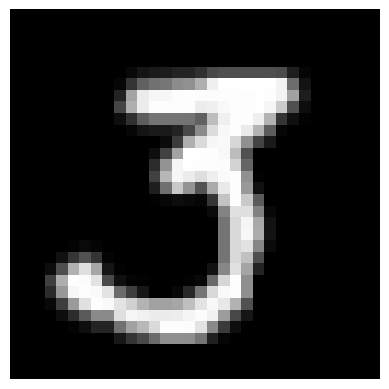

In [ ]:
for batch in test_loader:
    real_img, _ = batch  # Assuming the test loader returns (data, labels) tuple, and we only need "data"
    break  # Break after getting the first batch

for batch in test_loader:
    real_img, ground_truth_labels = batch  # Assuming the test loader returns (data, labels) tuple
    real_img = real_img.to(device)
    ground_truth_labels = ground_truth_labels.to(device)
    break  # Break after getting the first batch

real_img = real_img.to(device)

real_img.shape



# Ensure it's on the CPU and convert it to a NumPy array
real_img_1_smpl = real_img[0].cpu().numpy()
# Remove the channel dimension (if it's grayscale)
real_img_1_smpl = real_img_1_smpl[0]
# Visualize the sample
plt.imshow(real_img_1_smpl, cmap='gray')  # Assuming it's a grayscale image
plt.axis('off')  # Remove axis labels
plt.show()



### Regarding downsampling, with a stride of 2 in each convolutional layer, the **spatial dimensions of the feature maps are reduced**. However, the **number of channels (filters) increases as you go deeper** into the network. This is a common practice in CNN architectures to capture higher-level features in deeper layers while reducing spatial dimensions to manage computational complexity. The idea is that the network can learn to extract more abstract and complex patterns as it goes deeper into the layers.

### In the initial layers, the network learns basic features like **edges and simple patterns**. As you go deeper, it starts to combine these basic features to recognize more complex shapes, textures, and structures in the data. To do this, it needs more filters (channels) to capture the diversity of features in the input.

In [ ]:

# ------------------------------------ Load from Drive

from google.colab import drive
drive.mount('/content/drive')


# when CUDA:
activations_path = "/content/drive/MyDrive/activations_epoch_50.pkl"
with open(activations_path, 'rb') as file:
    epoch_activations = pickle.load(file)

# Load the activations from the file
activations_path_overfiring = "/content/drive/MyDrive/activations_epoch_50_OverFiring.pkl"
with open(activations_path_overfiring, 'rb') as file:
    epoch_activations_OverFiring = pickle.load(file)



Mounted at /content/drive


In [ ]:
hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]
# len(hook_names)


In [ ]:
Bnchmrk_Enc_Lk1_1 = Bnchmrk_Enc_Lk1[0]
Bnchmrk_Enc_Syn1_1 = Bnchmrk_Enc_Syn1[0]
Bnchmrk_Enc_Syn2_1 = Bnchmrk_Enc_Syn2[0]
Bnchmrk_Enc_Lk2_1 = Bnchmrk_Enc_Lk2
Bnchmrk_Dec_Lk1_1 = Bnchmrk_Dec_Lk1[0]
Bnchmrk_Dec_Syn1_1 = Bnchmrk_Dec_Syn1[0]
Bnchmrk_Dec_Syn2_1 = Bnchmrk_Dec_Syn2[0]
Bnchmrk_Dec_Lk2_1 = Bnchmrk_Dec_Lk2[1]

Ovrfrng_Enc_Lk1_1 = Ovrfrng_Enc_Lk1[0]
Ovrfrng_Enc_Syn1_1 = Ovrfrng_Enc_Syn1[0]
Ovrfrng_Enc_Syn2_1 = Ovrfrng_Enc_Syn2[0]
Ovrfrng_Enc_Lk2_1 = Ovrfrng_Enc_Lk2
Ovrfrng_Dec_Lk1_1 = Ovrfrng_Dec_Lk1[0]
Ovrfrng_Dec_Syn1_1 = Ovrfrng_Dec_Syn1[0]
Ovrfrng_Dec_Syn2_1 = Ovrfrng_Dec_Syn2[0]
Ovrfrng_Dec_Lk2_1 = Ovrfrng_Dec_Lk2[1]

print('real_img.shape:     ', real_img.shape)
print('real_img[0].shape:     ', real_img[0].shape)
print('\n')
print('Bnchmrk_Enc_Lk1_1.shape:     ', Bnchmrk_Enc_Lk1_1.shape)
print('Bnchmrk_Enc_Syn1_1.shape:     ', Bnchmrk_Enc_Syn1_1.shape)
print('Bnchmrk_Enc_Syn2_1.shape:     ', Bnchmrk_Enc_Syn2_1.shape)
print('Bnchmrk_Enc_Lk2_1.shape:     ', Bnchmrk_Enc_Lk2_1.shape)
print('Bnchmrk_Dec_Lk1_1.shape:     ', Bnchmrk_Dec_Lk1_1.shape)
print('Bnchmrk_Dec_Syn1_1.shape:     ', Bnchmrk_Dec_Syn1_1.shape)
print('Bnchmrk_Dec_Syn2_1.shape:     ', Bnchmrk_Dec_Syn2_1.shape)
print('Bnchmrk_Dec_Lk2_1.shape:     ', Bnchmrk_Dec_Lk2_1.shape)
print('\n')
print('Ovrfrng_Enc_Lk1_1.shape:     ', Ovrfrng_Enc_Lk1_1.shape)
print('Ovrfrng_Enc_Syn1_1.shape:     ', Ovrfrng_Enc_Syn1_1.shape)
print('Ovrfrng_Enc_Syn2_1.shape:     ', Ovrfrng_Enc_Syn2_1.shape)
print('Ovrfrng_Enc_Lk2_1.shape:     ', Ovrfrng_Enc_Lk2_1.shape)
print('Ovrfrng_Dec_Lk1_1.shape:     ', Ovrfrng_Dec_Lk1_1.shape)
print('Ovrfrng_Dec_Syn1_1.shape:     ', Ovrfrng_Dec_Syn1_1.shape)
print('Ovrfrng_Dec_Syn2_1.shape:     ', Ovrfrng_Dec_Syn2_1.shape)
print('Ovrfrng_Dec_Lk2_1.shape:     ', Ovrfrng_Dec_Lk2_1.shape)



NameError: ignored

### MSE loss for each layer between Overfiring and Benchmark

In [ ]:
import torch.nn.functional as F

MSE_Enc_Lk1_1= F.mse_loss(Bnchmrk_Enc_Lk1_1, Ovrfrng_Enc_Lk1_1)
print(f"MSE Loss Enc_Lk1_1: {MSE_Enc_Lk1_1.item()}")
MSE_Enc_Syn1_1= F.mse_loss(Bnchmrk_Enc_Syn1_1, Ovrfrng_Enc_Syn1_1)
print(f"MSE Loss Enc_Syn1: {MSE_Enc_Syn1_1.item()}")
MSE_Enc_Syn2_1= F.mse_loss(Bnchmrk_Enc_Syn2_1, Ovrfrng_Enc_Syn2_1)
print(f"MSE Loss Enc_Syn2: {MSE_Enc_Syn2_1.item()}")
MSE_Enc_Lk2= F.mse_loss(Bnchmrk_Enc_Lk2, Ovrfrng_Enc_Lk2)
print(f"MSE Loss Enc_Lk2: {MSE_Enc_Lk2.item()}")
print('\n')

MSE_Dec_Lk1_1= F.mse_loss(Bnchmrk_Dec_Lk1_1, Ovrfrng_Dec_Lk1_1)
print(f"MSE Loss Dec_Lk1_1: {MSE_Dec_Lk1_1.item()}")
MSE_Dec_Syn1_1= F.mse_loss(Bnchmrk_Dec_Syn1_1, Ovrfrng_Dec_Syn1_1)
print(f"MSE Loss Dec_Syn1_1: {MSE_Dec_Syn1_1.item()}")
MSE_Dec_Syn2_1= F.mse_loss(Bnchmrk_Dec_Syn2_1, Ovrfrng_Dec_Syn2_1)
print(f"MSE Loss Dec_Syn2_1: {MSE_Dec_Syn2_1.item()}")
MSE_Dec_Lk2_1= F.mse_loss(Bnchmrk_Dec_Lk2_1, Ovrfrng_Dec_Lk2_1)
print(f"MSE Loss Dec_Lk2_1: {MSE_Dec_Lk2_1.item()}")

print('------------')
MSE_real_Bnchmrk= F.mse_loss(real_img[0], Bnchmrk_Dec_Lk2_1)
print(f"MSE Loss Real vs Bnchmrk: {MSE_real_Bnchmrk.item()}")
MSE_real_Ovrfrng= F.mse_loss(real_img[0], Ovrfrng_Dec_Lk2_1)
print(f"MSE Loss Real vs Ovrfrng: {MSE_real_Ovrfrng.item()}")


NameError: ignored

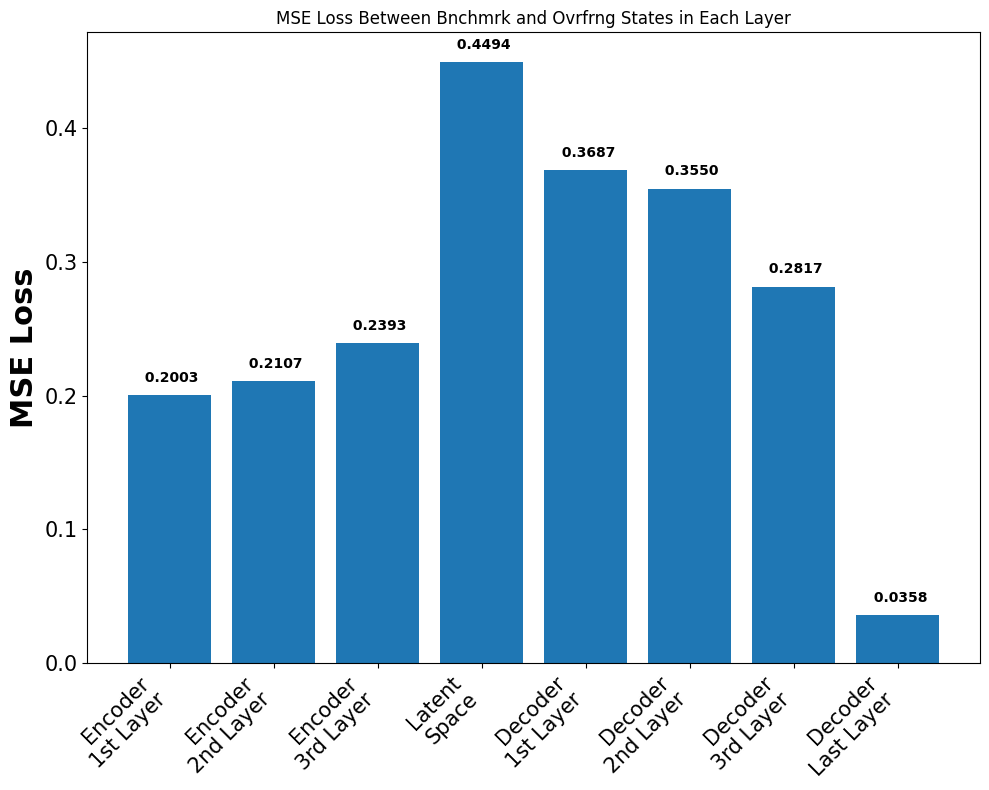

In [ ]:

font_size = 15
font = {'weight': 'bold', 'size': 22}
# Define the layers and their corresponding MSE losses
layers = ["Encoder\n1st Layer", "Encoder\n2nd Layer", "Encoder\n3rd Layer", "Latent\nSpace" ,"Decoder\n1st Layer", "Decoder\n2nd Layer", "Decoder\n3rd Layer", "Decoder\nLast Layer"]


mse_losses = [
    0.2003173828125, 0.210693359375, 0.2392578125, 0.4493750333786011,
    0.36865234375, 0.35498046875, 0.28173828125, 0.03579326719045639
]

# Create a vertical bar plot
plt.figure(figsize=(10, 8))
plt.bar(layers, mse_losses)
plt.ylabel('MSE Loss', fontdict=font)
plt.title('MSE Loss Between Bnchmrk and Ovrfrng States in Each Layer')
plt.xticks(rotation=45, ha='right')

# Display the MSE values on top of the bars
for i, loss in enumerate(mse_losses):
    plt.text(layers[i], loss+0.01, f' {loss:.4f}', ha='center', fontsize=10, fontweight='bold')

plt.tick_params(labelsize=font_size)
plt.tight_layout()
plt.show()

In [ ]:
# import pickle
# import torch

# benchmarks_save_path = '/content/benchmark_layers.pkl'
# overfiring_save_path = '/content/overfiring_layers.pkl'


# # Load the pickle files
# with open(benchmarks_save_path, 'rb') as file:
#     benchmark_layers = torch.load(file)

# with open(overfiring_save_path, 'rb') as file:
#     overfiring_layers = torch.load(file)

# # # Access the data
# # Bnchmrk_Enc_Lk1 = benchmark_layers['Bnchmrk_Enc_Lk1']
# # Bnchmrk_Enc_Syn1 = benchmark_layers['Bnchmrk_Enc_Syn1']
# # Bnchmrk_Enc_Syn2 = benchmark_layers['Bnchmrk_Enc_Syn2']
# # Bnchmrk_Enc_Lk2 = benchmark_layers['Bnchmrk_Enc_Lk2']
# # Bnchmrk_Dec_Lk1 = benchmark_layers['Bnchmrk_Dec_Lk1']
# # Bnchmrk_Dec_Syn1 = benchmark_layers['Bnchmrk_Dec_Syn1']
# # Bnchmrk_Dec_Syn2 = benchmark_layers['Bnchmrk_Dec_Syn2']
# # Bnchmrk_Dec_Lk2 = benchmark_layers['Bnchmrk_Dec_Lk2']

# # Ovrfrng_Enc_Lk1 = overfiring_layers['Ovrfrng_Enc_Lk1']
# # Ovrfrng_Enc_Syn1 = overfiring_layers['Ovrfrng_Enc_Syn1']
# # Ovrfrng_Enc_Syn2 = overfiring_layers['Ovrfrng_Enc_Syn2']
# # Ovrfrng_Enc_Lk2 = overfiring_layers['Ovrfrng_Enc_Lk2']
# # Ovrfrng_Dec_Lk1 = overfiring_layers['Ovrfrng_Dec_Lk1']
# # Ovrfrng_Dec_Syn1 = overfiring_layers['Ovrfrng_Dec_Syn1']
# # Ovrfrng_Dec_Syn2 = overfiring_layers['Ovrfrng_Dec_Syn2']
# # Ovrfrng_Dec_Lk2 = overfiring_layers['Ovrfrng_Dec_Lk2']


In [ ]:
import numpy as np

Bnchmrk_Enc_Lk1 = epoch_activations[48][hook_names[0]]
print("shape of Bnchmrk_Enc_Lk1:     ", Bnchmrk_Enc_Lk1.shape)
Bnchmrk_Enc_Lk1 = torch.tensor(Bnchmrk_Enc_Lk1)
Bnchmrk_Enc_Lk1 = torch.sum(Bnchmrk_Enc_Lk1, dim=(0, 1)).cpu().numpy()
print("shape of Bnchmrk_Enc_Lk1------------summed dim=(0, 1):   ", Bnchmrk_Enc_Lk1.shape)
Bnchmrk_Enc_Syn1 = epoch_activations[48][hook_names[1]]
Bnchmrk_Enc_Syn1 = torch.tensor(Bnchmrk_Enc_Syn1)
Bnchmrk_Enc_Syn1 = torch.sum(Bnchmrk_Enc_Syn1, dim=(0, 1)).cpu().numpy()
Bnchmrk_Enc_Syn2 = epoch_activations[48][hook_names[2]]
Bnchmrk_Enc_Syn2 = torch.tensor(Bnchmrk_Enc_Syn2)
Bnchmrk_Enc_Syn2 = torch.sum(Bnchmrk_Enc_Syn2, dim=(0, 1)).cpu().numpy()
Bnchmrk_Enc_Lk2 = epoch_activations[48][hook_names[3]][0]
print("shape of Bnchmrk_Enc_Lk2:     ", Bnchmrk_Enc_Lk2.shape)
Bnchmrk_Enc_Lk2 = Bnchmrk_Enc_Lk2.cpu().numpy()
print("shape of Bnchmrk_Enc_Lk2------------torch.tensor:   ", Bnchmrk_Enc_Lk2.shape)

Bnchmrk_Dec_Lk1 = epoch_activations[48][hook_names[4]]
Bnchmrk_Dec_Lk1 = torch.tensor(Bnchmrk_Dec_Lk1)
Bnchmrk_Dec_Lk1 = torch.sum(Bnchmrk_Dec_Lk1, dim=(0, 1)).cpu().numpy()
Bnchmrk_Dec_Syn1 = epoch_activations[48][hook_names[5]]
Bnchmrk_Dec_Syn1 = torch.tensor(Bnchmrk_Dec_Syn1)
Bnchmrk_Dec_Syn1 = torch.sum(Bnchmrk_Dec_Syn1, dim=(0, 1)).cpu().numpy()
Bnchmrk_Dec_Syn2 = epoch_activations[48][hook_names[6]]
Bnchmrk_Dec_Syn2 = torch.tensor(Bnchmrk_Dec_Syn2)
Bnchmrk_Dec_Syn2 = torch.sum(Bnchmrk_Dec_Syn2, dim=(0, 1)).cpu().numpy()
Bnchmrk_Dec_Lk2 = epoch_activations[48][hook_names[7]][1]
Bnchmrk_Dec_Lk2 = torch.tensor(Bnchmrk_Dec_Lk2)
Bnchmrk_Dec_Lk2 = torch.sum(Bnchmrk_Dec_Lk2, dim=(0, 1)).cpu().numpy()

# ----------- overfiring
Ovrfrng_Enc_Lk1 = epoch_activations_OverFiring[48][hook_names[0]]
Ovrfrng_Enc_Lk1 = torch.tensor(Ovrfrng_Enc_Lk1)
Ovrfrng_Enc_Lk1 = torch.sum(Ovrfrng_Enc_Lk1, dim=(0, 1)).cpu().numpy()
Ovrfrng_Enc_Syn1 = epoch_activations_OverFiring[48][hook_names[1]]
Ovrfrng_Enc_Syn1 = torch.tensor(Ovrfrng_Enc_Syn1)
Ovrfrng_Enc_Syn1 = torch.sum(Ovrfrng_Enc_Syn1, dim=(0, 1)).cpu().numpy()
Ovrfrng_Enc_Syn2 = epoch_activations_OverFiring[48][hook_names[2]]
Ovrfrng_Enc_Syn2 = torch.tensor(Ovrfrng_Enc_Syn2)
Ovrfrng_Enc_Syn2 = torch.sum(Ovrfrng_Enc_Syn2, dim=(0, 1)).cpu().numpy()
Ovrfrng_Enc_Lk2 = epoch_activations_OverFiring[48][hook_names[3]][0]
Ovrfrng_Enc_Lk2 = Ovrfrng_Enc_Lk2.cpu().numpy()

Ovrfrng_Dec_Lk1 = epoch_activations_OverFiring[48][hook_names[4]]
Ovrfrng_Dec_Lk1 = torch.tensor(Ovrfrng_Dec_Lk1)
Ovrfrng_Dec_Lk1 = torch.sum(Ovrfrng_Dec_Lk1, dim=(0, 1)).cpu().numpy()
Ovrfrng_Dec_Syn1 = epoch_activations_OverFiring[48][hook_names[5]]
Ovrfrng_Dec_Syn1 = torch.tensor(Ovrfrng_Dec_Syn1)
Ovrfrng_Dec_Syn1 = torch.sum(Ovrfrng_Dec_Syn1, dim=(0, 1)).cpu().numpy()
Ovrfrng_Dec_Syn2 = epoch_activations_OverFiring[48][hook_names[6]]
Ovrfrng_Dec_Syn2 = torch.tensor(Ovrfrng_Dec_Syn2)
Ovrfrng_Dec_Syn2 = torch.sum(Ovrfrng_Dec_Syn2, dim=(0, 1)).cpu().numpy()
Ovrfrng_Dec_Lk2 = epoch_activations_OverFiring[48][hook_names[7]][1]
Ovrfrng_Dec_Lk2 = torch.tensor(Ovrfrng_Dec_Lk2)
Ovrfrng_Dec_Lk2 = torch.sum(Ovrfrng_Dec_Lk2, dim=(0, 1)).cpu().numpy()


# Define a function to calculate entropy
def entropy(data):
    # Normalize data to [0, 1]
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    # Compute entropy
    p = normalized_data / np.sum(normalized_data)
    entropy = -np.sum(p * np.log2(p + 1e-10))
    return entropy

# # Calculate entropy for each layer's data
# entropy_Lk1 = entropy(Bnchmrk_Enc_Lk1)
# entropy_Syn1 = entropy(Bnchmrk_Enc_Syn1)
# entropy_Syn2 = entropy(Bnchmrk_Enc_Syn2)
# entropy_Lk2 = entropy(Bnchmrk_Enc_Lk2)

# print("Entropy of Bnchmrk_Enc_Lk1:", entropy_Lk1)
# print("Entropy of Bnchmrk_Enc_Syn1:", entropy_Syn1)
# print("Entropy of Bnchmrk_Enc_Syn2:", entropy_Syn2)
# print("Entropy of Bnchmrk_Enc_Lk2:", entropy_Lk2)


hook_names = ["Enc_Lk1", "Enc_Syn1", "Enc_Syn2", "Enc_Lk2", "Dec_Lk1", "Dec_Syn1", "Dec_Syn2", "Dec_Lk2"]

# Create a dictionary to store entropy values for each layer
entropy_values_benchmark = {}
entropy_values_overfiring = {}

# Calculate entropy for each layer's data
for name in hook_names:
    data_benchmark = globals()[f'Bnchmrk_{name}']
    data_overfiring = globals()[f'Ovrfrng_{name}']

    entropy_benchmark = entropy(data_benchmark)
    entropy_overfiring = entropy(data_overfiring)

    entropy_values_benchmark[name] = entropy_benchmark
    entropy_values_overfiring[name] = entropy_overfiring

    print(f"Entropy of Bnchmrk_{name}:", entropy_benchmark)
    print(f"Entropy of Ovrfrng_{name}:", entropy_overfiring)

# Print all entropy values
for name in hook_names:
    print(f"Entropy of Bnchmrk_{name}:", entropy_values_benchmark[name])
    print(f"Entropy of Ovrfrng_{name}:", entropy_values_overfiring[name])



shape of Bnchmrk_Enc_Lk1:      torch.Size([250, 32, 16, 16])
shape of Bnchmrk_Enc_Lk1------------summed dim=(0, 1):    (16, 16)
shape of Bnchmrk_Enc_Lk2:      torch.Size([250, 32])
shape of Bnchmrk_Enc_Lk2------------torch.tensor:    (250, 32)
Entropy of Bnchmrk_Enc_Lk1: 7.575762
Entropy of Ovrfrng_Enc_Lk1: 6.9702387
Entropy of Bnchmrk_Enc_Syn1: 5.666358
Entropy of Ovrfrng_Enc_Syn1: 5.852501
Entropy of Bnchmrk_Enc_Syn2: 3.4452271
Entropy of Ovrfrng_Enc_Syn2: 3.5858417
Entropy of Bnchmrk_Enc_Lk2: 12.400877
Entropy of Ovrfrng_Enc_Lk2: 12.2799
Entropy of Bnchmrk_Dec_Lk1: 3.647652
Entropy of Ovrfrng_Dec_Lk1: 3.595449
Entropy of Bnchmrk_Dec_Syn1: 5.7325373
Entropy of Ovrfrng_Dec_Syn1: 5.7713776
Entropy of Bnchmrk_Dec_Syn2: 7.67945
Entropy of Ovrfrng_Dec_Syn2: 7.5578184
Entropy of Bnchmrk_Dec_Lk2: 9.508827
Entropy of Ovrfrng_Dec_Lk2: 9.634359
Entropy of Bnchmrk_Enc_Lk1: 7.575762
Entropy of Ovrfrng_Enc_Lk1: 6.9702387
Entropy of Bnchmrk_Enc_Syn1: 5.666358
Entropy of Ovrfrng_Enc_Syn1: 5.852501


<ipython-input-23-1c09ca751557>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Bnchmrk_Enc_Lk1 = torch.tensor(Bnchmrk_Enc_Lk1)
<ipython-input-23-1c09ca751557>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Bnchmrk_Enc_Syn1 = torch.tensor(Bnchmrk_Enc_Syn1)
<ipython-input-23-1c09ca751557>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Bnchmrk_Enc_Syn2 = torch.tensor(Bnchmrk_Enc_Syn2)
<ipython-input-23-1c09ca751557>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor

In [ ]:
import numpy as np

import torch

# Initial activations
Bnchmrk_Enc_Lk1 = epoch_activations[48][hook_names[0]]
print("shape of Bnchmrk_Enc_Lk1:     ", Bnchmrk_Enc_Lk1.shape)

# Convert to PyTorch tensor and sum over dimensions (0, 1)
Bnchmrk_Enc_Lk1_tensor = torch.tensor(Bnchmrk_Enc_Lk1)
Bnchmrk_Enc_Lk1_sum = torch.sum(Bnchmrk_Enc_Lk1_tensor, dim=(0, 1)).cpu().numpy()
print("shape of Bnchmrk_Enc_Lk1------------summed dim=(0, 1):   ", Bnchmrk_Enc_Lk1_sum.shape)

# Repeat the same process for other variables
Bnchmrk_Enc_Syn1 = epoch_activations[48][hook_names[1]]
Bnchmrk_Enc_Syn1_tensor = torch.tensor(Bnchmrk_Enc_Syn1)
Bnchmrk_Enc_Syn1_sum = torch.sum(Bnchmrk_Enc_Syn1_tensor, dim=(0, 1)).cpu().numpy()

Bnchmrk_Enc_Syn2 = epoch_activations[48][hook_names[2]]
Bnchmrk_Enc_Syn2_tensor = torch.tensor(Bnchmrk_Enc_Syn2)
Bnchmrk_Enc_Syn2_sum = torch.sum(Bnchmrk_Enc_Syn2_tensor, dim=(0, 1)).cpu().numpy()

Bnchmrk_Enc_Lk2 = epoch_activations[48][hook_names[3]][0]
print("shape of Bnchmrk_Enc_Lk2:     ", Bnchmrk_Enc_Lk2.shape)
Bnchmrk_Enc_Lk2_sum = Bnchmrk_Enc_Lk2.cpu().numpy()
print("shape of Bnchmrk_Enc_Lk2------------torch.tensor:   ", Bnchmrk_Enc_Lk2_sum.shape)

# Repeat for decoder variables
Bnchmrk_Dec_Lk1 = epoch_activations[48][hook_names[4]]
Bnchmrk_Dec_Lk1_tensor = torch.tensor(Bnchmrk_Dec_Lk1)
Bnchmrk_Dec_Lk1_sum = torch.sum(Bnchmrk_Dec_Lk1_tensor, dim=(0, 1)).cpu().numpy()

Bnchmrk_Dec_Syn1 = epoch_activations[48][hook_names[5]]
Bnchmrk_Dec_Syn1_tensor = torch.tensor(Bnchmrk_Dec_Syn1)
Bnchmrk_Dec_Syn1_sum = torch.sum(Bnchmrk_Dec_Syn1_tensor, dim=(0, 1)).cpu().numpy()

Bnchmrk_Dec_Syn2 = epoch_activations[48][hook_names[6]]
Bnchmrk_Dec_Syn2_tensor = torch.tensor(Bnchmrk_Dec_Syn2)
Bnchmrk_Dec_Syn2_sum = torch.sum(Bnchmrk_Dec_Syn2_tensor, dim=(0, 1)).cpu().numpy()

Bnchmrk_Dec_Lk2 = epoch_activations[48][hook_names[7]][1]
Bnchmrk_Dec_Lk2_tensor = torch.tensor(Bnchmrk_Dec_Lk2)
Bnchmrk_Dec_Lk2_sum = torch.sum(Bnchmrk_Dec_Lk2_tensor, dim=(0, 1)).cpu().numpy()

# Overfiring state variables
Ovrfrng_Enc_Lk1 = epoch_activations_OverFiring[48][hook_names[0]]
Ovrfrng_Enc_Lk1_tensor = torch.tensor(Ovrfrng_Enc_Lk1)
Ovrfrng_Enc_Lk1_sum = torch.sum(Ovrfrng_Enc_Lk1_tensor, dim=(0, 1)).cpu().numpy()

Ovrfrng_Enc_Syn1 = epoch_activations_OverFiring[48][hook_names[1]]
Ovrfrng_Enc_Syn1_tensor = torch.tensor(Ovrfrng_Enc_Syn1)
Ovrfrng_Enc_Syn1_sum = torch.sum(Ovrfrng_Enc_Syn1_tensor, dim=(0, 1)).cpu().numpy()

Ovrfrng_Enc_Syn2 = epoch_activations_OverFiring[48][hook_names[2]]
Ovrfrng_Enc_Syn2_tensor = torch.tensor(Ovrfrng_Enc_Syn2)
Ovrfrng_Enc_Syn2_sum = torch.sum(Ovrfrng_Enc_Syn2_tensor, dim=(0, 1)).cpu().numpy()

Ovrfrng_Enc_Lk2 = epoch_activations_OverFiring[48][hook_names[3]][0]
Ovrfrng_Enc_Lk2_sum = Ovrfrng_Enc_Lk2.cpu().numpy()

Ovrfrng_Dec_Lk1 = epoch_activations_OverFiring[48][hook_names[4]]
Ovrfrng_Dec_Lk1_tensor = torch.tensor(Ovrfrng_Dec_Lk1)
Ovrfrng_Dec_Lk1_sum = torch.sum(Ovrfrng_Dec_Lk1_tensor, dim=(0, 1)).cpu().numpy()

Ovrfrng_Dec_Syn1 = epoch_activations_OverFiring[48][hook_names[5]]
Ovrfrng_Dec_Syn1_tensor = torch.tensor(Ovrfrng_Dec_Syn1)
Ovrfrng_Dec_Syn1_sum = torch.sum(Ovrfrng_Dec_Syn1_tensor, dim=(0, 1)).cpu().numpy()

Ovrfrng_Dec_Syn2 = epoch_activations_OverFiring[48][hook_names[6]]
Ovrfrng_Dec_Syn2_tensor = torch.tensor(Ovrfrng_Dec_Syn2)
Ovrfrng_Dec_Syn2_sum = torch.sum(Ovrfrng_Dec_Syn2_tensor, dim=(0, 1)).cpu().numpy()

Ovrfrng_Dec_Lk2 = epoch_activations_OverFiring[48][hook_names[7]][1]
Ovrfrng_Dec_Lk2_tensor = torch.tensor(Ovrfrng_Dec_Lk2)
Ovrfrng_Dec_Lk2_sum = torch.sum(Ovrfrng_Dec_Lk2_tensor, dim=(0, 1)).cpu().numpy()

# Define a function to calculate entropy
def entropy(data):
    # Normalize data to [0, 1]
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    # Compute entropy
    p = normalized_data / np.sum(normalized_data)
    entropy = -np.sum(p * np.log2(p + 1e-10))
    return entropy

# # Calculate entropy for each layer's data
# entropy_Lk1 = entropy(Bnchmrk_Enc_Lk1)
# entropy_Syn1 = entropy(Bnchmrk_Enc_Syn1)
# entropy_Syn2 = entropy(Bnchmrk_Enc_Syn2)
# entropy_Lk2 = entropy(Bnchmrk_Enc_Lk2)

# print("Entropy of Bnchmrk_Enc_Lk1:", entropy_Lk1)
# print("Entropy of Bnchmrk_Enc_Syn1:", entropy_Syn1)
# print("Entropy of Bnchmrk_Enc_Syn2:", entropy_Syn2)
# print("Entropy of Bnchmrk_Enc_Lk2:", entropy_Lk2)


hook_names = ["Enc_Lk1", "Enc_Syn1", "Enc_Syn2", "Enc_Lk2", "Dec_Lk1", "Dec_Syn1", "Dec_Syn2", "Dec_Lk2"]

# Create a dictionary to store entropy values for each layer
entropy_values_benchmark = {}
entropy_values_overfiring = {}

# Calculate entropy for each layer's data
for name in hook_names:
    data_benchmark = globals()[f'Bnchmrk_{name}_sum']
    data_overfiring = globals()[f'Ovrfrng_{name}_sum']

    entropy_benchmark = entropy(data_benchmark)
    entropy_overfiring = entropy(data_overfiring)

    entropy_values_benchmark[name] = entropy_benchmark
    entropy_values_overfiring[name] = entropy_overfiring

    print(f"Entropy of Bnchmrk_{name}:", entropy_benchmark)
    print(f"Entropy of Ovrfrng_{name}:", entropy_overfiring)

print('\n')
print('\n')
print('\n')
# # Print all entropy values
# for name in hook_names:
#     print(f"Entropy of Bnchmrk_{name}:", entropy_values_benchmark[name])
#     print(f"Entropy of Ovrfrng_{name}:", entropy_values_overfiring[name])



shape of Bnchmrk_Enc_Lk1:      torch.Size([250, 32, 16, 16])
shape of Bnchmrk_Enc_Lk1------------summed dim=(0, 1):    (16, 16)
shape of Bnchmrk_Enc_Lk2:      torch.Size([250, 32])
shape of Bnchmrk_Enc_Lk2------------torch.tensor:    (250, 32)
Entropy of Bnchmrk_Enc_Lk1: 7.575762
Entropy of Ovrfrng_Enc_Lk1: 6.9702387
Entropy of Bnchmrk_Enc_Syn1: 5.666358
Entropy of Ovrfrng_Enc_Syn1: 5.852501
Entropy of Bnchmrk_Enc_Syn2: 3.4452271
Entropy of Ovrfrng_Enc_Syn2: 3.5858417
Entropy of Bnchmrk_Enc_Lk2: 12.400877
Entropy of Ovrfrng_Enc_Lk2: 12.2799
Entropy of Bnchmrk_Dec_Lk1: 3.647652
Entropy of Ovrfrng_Dec_Lk1: 3.595449
Entropy of Bnchmrk_Dec_Syn1: 5.7325373
Entropy of Ovrfrng_Dec_Syn1: 5.7713776
Entropy of Bnchmrk_Dec_Syn2: 7.6794505
Entropy of Ovrfrng_Dec_Syn2: 7.5578184
Entropy of Bnchmrk_Dec_Lk2: 9.508827
Entropy of Ovrfrng_Dec_Lk2: 9.634359








<ipython-input-56-114633ef1b4f>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Bnchmrk_Enc_Lk1_tensor = torch.tensor(Bnchmrk_Enc_Lk1)
<ipython-input-56-114633ef1b4f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Bnchmrk_Enc_Syn1_tensor = torch.tensor(Bnchmrk_Enc_Syn1)
<ipython-input-56-114633ef1b4f>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Bnchmrk_Enc_Syn2_tensor = torch.tensor(Bnchmrk_Enc_Syn2)
<ipython-input-56-114633ef1b4f>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().d

### One Digit


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import os


# Assuming you have loaded the data and the model as in your previous code
for batch in test_loader:
    real_img, _ = batch  # Assuming the test loader returns (data, labels) tuple, and we only need "data"
    break  # Break after getting the first batch

# Choose a specific index to plot (e.g., the first digit in the batch)
index_to_plot = 0

# Get the specific digit's image
real_img_to_plot = real_img[index_to_plot].unsqueeze(0).to(device)

# Display the input size
print("Input image size:", real_img_to_plot.shape)

# Now you can use the real_img_to_plot for your further operations
# For example, passing it through the model and plotting the results

# Pass the specific digit's image through the model to get reconstructed images
with torch.no_grad():
    reconstructed_image, _ = trained_net(real_img_to_plot)  # Assuming trained_net is your model

# Function to plot and save images
def save_image(image, title, save_path):
    plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
    plt.title(title)
    plt.axis('on')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Save the real input image
save_image(real_img_to_plot[0], "Real Input Image", "real_input_image.pdf")

# Save the reconstructed image
save_image(reconstructed_image[0], "Reconstructed Image", "reconstructed_image.pdf")


Input image size: torch.Size([1, 1, 32, 32])


NameError: ignored

KeyError: ignored

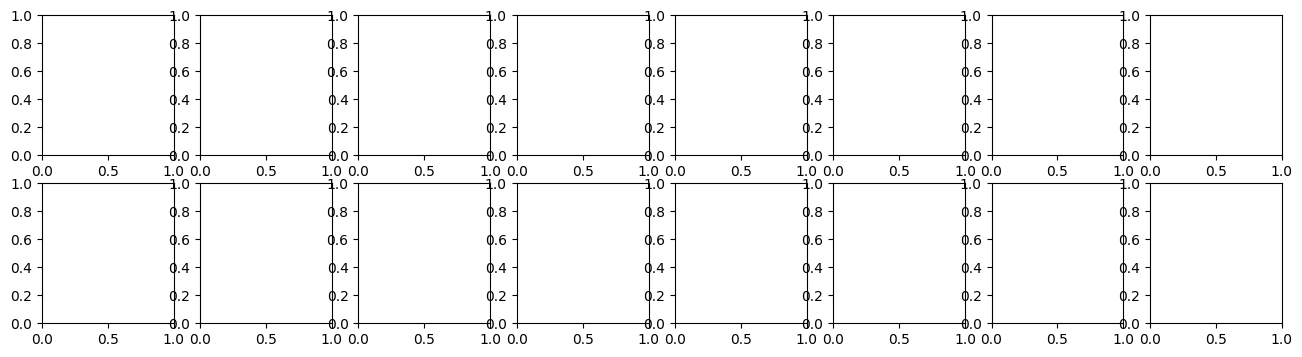

In [ ]:
import matplotlib.pyplot as plt

# Create a dictionary to store p values for each layer
p_values_benchmark = {}
p_values_overfiring = {}

# Create subplots for the histograms
fig, axes = plt.subplots(2, len(hook_names), figsize=(16, 4))

# Calculate entropy and p for each layer's data
for i, name in enumerate(hook_names):
    data_benchmark = globals()[f'Bnchmrk_{name}']
    data_overfiring = globals()[f'Ovrfrng_{name}']

    normalized_data_benchmark = (data_benchmark - np.min(data_benchmark)) / (np.max(data_benchmark) - np.min(data_benchmark))
    p_benchmark = normalized_data_benchmark / np.sum(normalized_data_benchmark)
    entropy_benchmark = -np.sum(p_benchmark * np.log2(p_benchmark + 1e-10))

    normalized_data_overfiring = (data_overfiring - np.min(data_overfiring)) / (np.max(data_overfiring) - np.min(data_overfiring))
    p_overfiring = normalized_data_overfiring / np.sum(normalized_data_overfiring)
    entropy_overfiring = -np.sum(p_overfiring * np.log2(p_overfiring + 1e-10))

    entropy_values_benchmark[name] = entropy_benchmark
    entropy_values_overfiring[name] = entropy_overfiring

    p_values_benchmark[name] = p_benchmark
    p_values_overfiring[name] = p_overfiring

    # Plot histogram of p values
    axes[0, i].hist(p_benchmark, bins=50, alpha=0.5, label='Benchmark')
    axes[0, i].set_title(f"P of Bnchmrk_{name}")

    axes[1, i].hist(p_overfiring, bins=50, alpha=0.5, label='Overfiring')
    axes[1, i].set_title(f"P of Ovrfrng_{name}")

# Add legend
axes[0, 0].legend()
axes[1, 0].legend()

# Show the plots
plt.tight_layout()
plt.show()


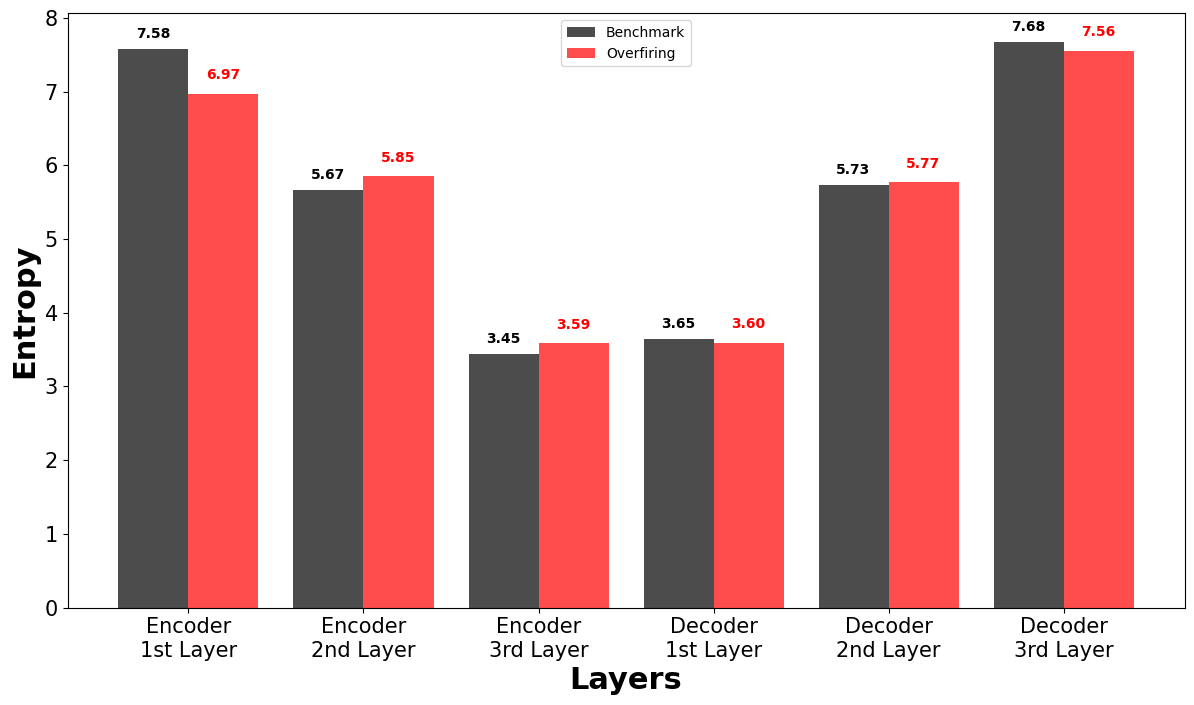

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
font_size = 15
font = {'weight': 'bold', 'size': 22}
colors = ["#FF0000", "#000000"]


# Entropy data
# layers = ["Enc_Lk1", "Enc_Syn1", "Enc_Syn2", "Enc_Lk2", "Dec_Lk1", "Dec_Syn1", "Dec_Syn2", "Dec_Lk2"]
# bench_entropy = [7.575762, 5.666358, 3.4452271, 12.400877, 3.647652, 5.7325373, 7.67945, 9.508827]
# ovrfrng_entropy = [6.9702387, 5.852501, 3.5858417, 12.2799, 3.595449, 5.7713776, 7.5578184, 9.634359]

# layers = ["Encoder\n1st Layer", "Encoder\n2nd Layer", "Encoder\n3rd Layer", "Latent\nspace", "Decoder\n1st Layer", "Decoder\n2nd Layer", "Decoder\n3rd Layer", "Decoder\nlast Layer"]
# bench_entropy = [7.575762, 5.666358, 3.4452271, 12.400877, 3.647652, 5.7325373, 7.67945, 9.508827]
# ovrfrng_entropy = [6.9702387, 5.852501, 3.5858417, 12.2799, 3.595449, 5.7713776, 7.5578184, 9.634359]

# layers = ["Encoder\n1st Layer", "Encoder\n2nd Layer", "Encoder\n3rd Layer", "Latent\nspace", "Decoder\n1st Layer", "Decoder\n2nd Layer", "Decoder\n3rd Layer"]
# bench_entropy = [7.575762, 5.666358, 3.4452271, 12.400877, 3.647652, 5.7325373, 7.67945]
# ovrfrng_entropy = [6.9702387, 5.852501, 3.5858417, 12.2799, 3.595449, 5.7713776, 7.5578184]

layers = ["Encoder\n1st Layer", "Encoder\n2nd Layer", "Encoder\n3rd Layer", "Decoder\n1st Layer", "Decoder\n2nd Layer", "Decoder\n3rd Layer"]
bench_entropy = [7.575762, 5.666358, 3.4452271, 3.647652, 5.7325373, 7.67945]
ovrfrng_entropy = [6.9702387, 5.852501, 3.5858417, 3.595449, 5.7713776, 7.5578184]

# Set up positions for the bars
x = np.arange(len(layers))

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the Benchmark entropy values
ax.bar(x - 0.2, bench_entropy, 0.4, label='Benchmark', alpha=0.7, color=colors[1])

# Plot the Overfiring entropy values
ax.bar(x + 0.2, ovrfrng_entropy, 0.4, label='Overfiring', alpha=0.7,color=colors[0])

# Labeling
ax.set_xlabel('Layers', fontdict=font)
ax.set_ylabel('Entropy', fontdict=font)
# ax.set_title('Entropy Comparison (Benchmark vs. Overfiring) for Each Layer\n')
ax.set_xticks(x)
ax.set_xticklabels(layers)

# Adding exact entropy values above each bar
for i, v in enumerate(bench_entropy):
    ax.text(i - 0.3, v + 0.15, f"{v:.2f}", color=colors[1], fontweight='bold')

for i, v in enumerate(ovrfrng_entropy):
    ax.text(i + 0.10, v + 0.2, f"{v:.2f}", color=colors[0], fontweight='bold')

ax.legend()

plt.tight_layout()
plt.tick_params(labelsize=font_size)
plt.show()



In [ ]:
# Sum all the entropy values for the benchmark and overfiring states
layers = ["Encoder\n1st Layer", "Encoder\n2nd Layer", "Encoder\n3rd Layer", "Decoder\n1st Layer", "Decoder\n2nd Layer", "Decoder\n3rd Layer"]
bench_entropy = [7.575762, 5.666358, 3.4452271, 3.647652, 5.7325373, 7.67945]
ovrfrng_entropy = [6.9702387, 5.852501, 3.5858417, 3.595449, 5.7713776, 7.5578184]
layers = ["Encoder\n1st Layer", "Encoder\n2nd Layer", "Encoder\n3rd Layer", "Decoder\n1st Layer", "Decoder\n2nd Layer", "Decoder\n3rd Layer"]
bench_entropy = [7.575762, 5.666358, 3.4452271, 3.647652, 5.7325373, 7.67945]
ovrfrng_entropy = [6.9702387, 5.852501, 3.5858417, 3.595449, 5.7713776, 7.5578184]

# Sum the entropy values for benchmark and overfiring states
total_bench_entropy = np.sum(bench_entropy)
total_ovrfrng_entropy = np.sum(ovrfrng_entropy)

# Compare the total entropy for the two states
if total_bench_entropy > total_ovrfrng_entropy:
    interpretation = "The benchmark state has higher total entropy, indicating more information diversity."
else:
    interpretation = "The overfiring state has higher total entropy, suggesting it retains more information diversity."

print("Total Entropy for Benchmark State:", total_bench_entropy)
print("Total Entropy for Overfiring State:", total_ovrfrng_entropy)
print("Interpretation:", interpretation)



Total Entropy for Benchmark State: 33.746986400000004
Total Entropy for Overfiring State: 33.3332264
Interpretation: The benchmark state has higher total entropy, indicating more information diversity.


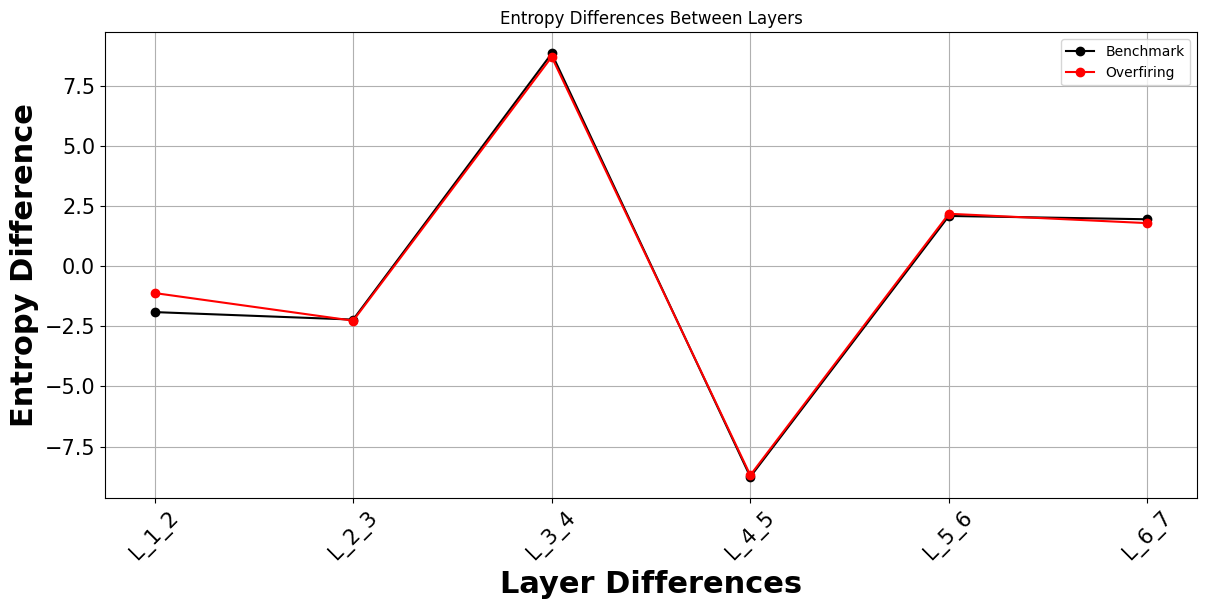

In [ ]:
# import matplotlib.pyplot as plt
# font_size = 15
# font = {'weight': 'bold', 'size': 22}

# # Benchmark and Overfiring Entropy values
# Bench_entropy_values = {
#     "L_1_2": (7.575762, 5.666358),
#     "L_2_3": (5.666358, 3.4452271),
#     "L_3_4": (3.4452271, 12.2799),
#     "L_4_5": (12.400877, 3.647652),
#     "L_5_6": (3.647652, 5.7325373),
#     "L_6_7": (5.7325373, 7.6794505),
#     # "L_7_8": (7.6794505, 9.508827),
# }

# Overf_entropy_values = {
#     "L_1_2": (6.9702387, 5.852501),
#     "L_2_3": (5.852501, 3.5858417),
#     "L_3_4": (3.5858417, 12.2799),
#     "L_4_5": (12.2799, 3.595449),
#     "L_5_6": (3.595449, 5.7713776),
#     "L_6_7": (5.7713776, 7.5578184),
#     # "L_7_8": (7.5578184, 9.634359),
# }

# # Extract the names and values
# names = list(Bench_entropy_values.keys())
# benchmark_values = list(Bench_entropy_values.values())
# overfiring_values = list(Overf_entropy_values.values())

# # Calculate differences in entropy
# benchmark_differences = [benchmark_values[i-1][1] - benchmark_values[i-1][0] for i in range(1, len(benchmark_values) + 1)]
# overfiring_differences = [overfiring_values[i-1][1] - overfiring_values[i-1][0] for i in range(1, len(overfiring_values) + 1)]

# # Plot benchmark and overfiring differences together
# plt.figure(figsize=(12, 6))
# plt.plot(names, benchmark_differences, marker='o', linestyle='-', color='#000000', label='Benchmark')
# plt.plot(names, overfiring_differences, marker='o', linestyle='-', color='#FF0000', label='Overfiring')
# plt.xlabel('Layer Differences', fontdict=font)
# plt.ylabel('Entropy Difference', fontdict=font)
# plt.title('Entropy Differences Between Layers')
# plt.xticks(rotation=45)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.tick_params(labelsize=font_size)

# # Show the combined plot
# plt.show()


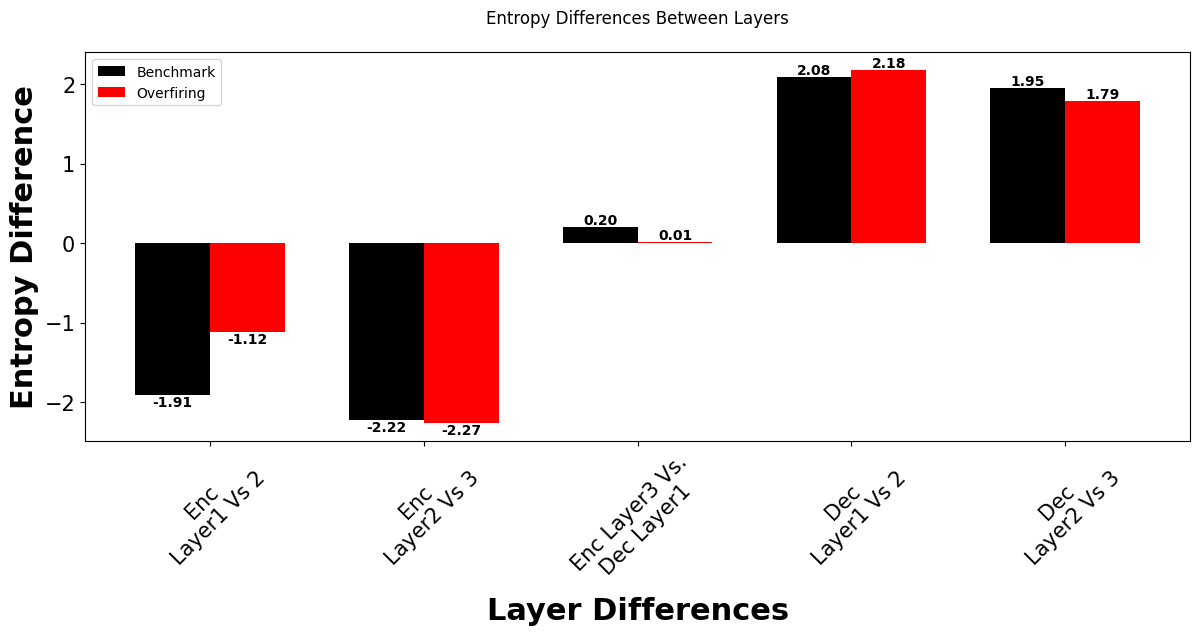

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

font_size = 15
font = {'weight': 'bold', 'size': 22}

# Benchmark and Overfiring Entropy values
Bench_entropy_values = {
    "Enc\nLayer1 Vs 2": (7.575762, 5.666358),
    "Enc\nLayer2 Vs 3": (5.666358, 3.4452271),
    # "Enc Layer3,\nLatent": (3.4452271, 12.2799),
    "Enc Layer3 Vs.\nDec Layer1": (3.4452271, 3.647652),
    # "Latent\nDec Layer1": (12.400877, 3.647652),
    "Dec\nLayer1 Vs 2": (3.647652, 5.7325373),
    "Dec\nLayer2 Vs 3": (5.7325373, 7.6794505),
    # "L_7_8": (7.6794505, 9.508827),
}

Overf_entropy_values = {
    "L_1_2": (6.9702387, 5.852501),
    "L_2_3": (5.852501, 3.5858417),
    # "L_3_4": (3.5858417, 12.2799),
    "L_3_5": (3.5858417, 3.595449),
    # "L_4_5": (12.2799, 3.595449),
    "L_5_6": (3.595449, 5.7713776),
    "L_6_7": (5.7713776, 7.5578184),
    # "L_7_8": (7.5578184, 9.634359),
}

# Extract the names and values
names = list(Bench_entropy_values.keys())
benchmark_values = list(Bench_entropy_values.values())
overfiring_values = list(Overf_entropy_values.values())

# Calculate differences in entropy
benchmark_differences = [benchmark_values[i-1][1] - benchmark_values[i-1][0] for i in range(1, len(benchmark_values) + 1)]
overfiring_differences = [overfiring_values[i-1][1] - overfiring_values[i-1][0] for i in range(1, len(overfiring_values) + 1)]

# Set the bar width
bar_width = 0.35

# Create an array of indices for the bars
index = np.arange(len(names))

# Plot benchmark and overfiring differences using bar plots
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, benchmark_differences, bar_width, label='Benchmark', color='#000000')
plt.bar(index + bar_width/2, overfiring_differences, bar_width, label='Overfiring', color='#FF0000')
plt.xlabel('Layer Differences', fontdict=font)
plt.ylabel('Entropy Difference', fontdict=font)
plt.title('Entropy Differences Between Layers\n')
plt.xticks(index, names, rotation=45)
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.tick_params(labelsize=font_size)


# Annotate each bar with its value, and adjust va based on the sign of the value
for i in range(len(index)):
    va = 'bottom' if benchmark_differences[i] >= 0 else 'top'
    plt.text(index[i] - bar_width/2, benchmark_differences[i], f'{benchmark_differences[i]:.2f}', ha='center', va=va, fontweight='bold')
    va = 'bottom' if overfiring_differences[i] >= 0 else 'top'
    plt.text(index[i] + bar_width/2, overfiring_differences[i], f'{overfiring_differences[i]:.2f}', ha='center', va=va, fontweight='bold')


# Show the combined bar plot with annotations
plt.show()


In [ ]:

# ------------------------------------ Load from Drive

from google.colab import drive
drive.mount('/content/drive')


# when CUDA:
activations_path = "/content/drive/MyDrive/activations_epoch_50.pkl"
with open(activations_path, 'rb') as file:
    epoch_activations = pickle.load(file)

# Load the activations from the file
activations_path_overfiring = "/content/drive/MyDrive/activations_epoch_50_OverFiring.pkl"
with open(activations_path_overfiring, 'rb') as file:
    epoch_activations_OverFiring = pickle.load(file)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]
# len(hook_names)


shape of Bnchmrk_Dec_syn2 torch.Size([250, 32, 16, 16])
shape of Ovrfrng_Dec_syn2 torch.Size([250, 32, 16, 16])
shape of Bnchmrk_Dec_syn2------------after sum (16, 16)
shape of Ovrfrng_Dec_syn2------------after sum (16, 16)


<ipython-input-37-4dba5b37b029>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Bnchmrk_Enc_Syn1 = torch.tensor(Bnchmrk_Enc_Syn1)
<ipython-input-37-4dba5b37b029>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ovrfrng_Enc_Syn1 = torch.tensor(Ovrfrng_Enc_Syn1)


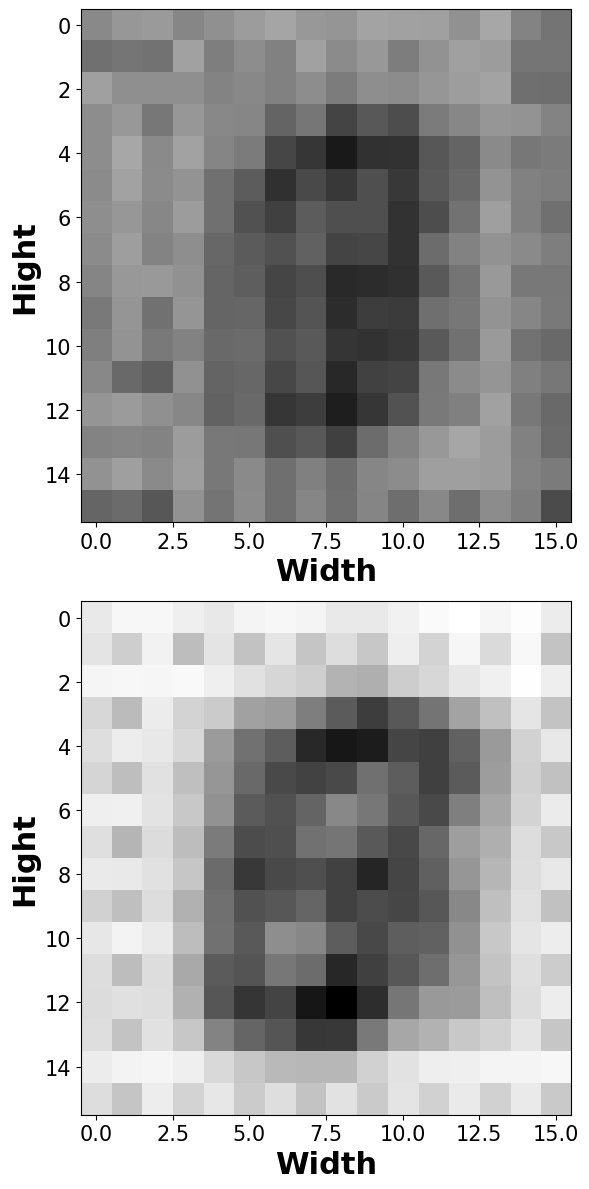

In [ ]:

# shape = (250, 64, 8, 8)
# random_tensor = torch.randint(0, 2, size=shape)
# random_tensor2 = torch.randint(0, 2, size=shape)
# Bnchmrk_Enc_Syn1 = random_tensor.float()
# Ovrfrng_Enc_Syn1 = random_tensor2.float()

# print(Bnchmrk_Enc_Syn1.shape)
# print(Ovrfrng_Enc_Syn1.shape)
# # ///////////////////////////////////////////////////////
# Provides a global summary of activity, where we're aggregating the information from all neurons and all data points.
# This representation could be useful for capturing high-level, global features of data but might lose some spatial information.

#The (8, 8) plot represents a simplified view of the original data.
# Each pixel in this plot corresponds to one element in the reduced tensor.
# The value of each pixel represents the sum of all values at the corresponding position across the batch and features dimensions in the original data.
# Essentially, it's a way of aggregating or summarizing the data.
# Each pixel in the (8, 8) plot summarizes the activity or information at a specific spatial location (a pixel) in the original data but aggregated across the entire batch and all features.
# If a pixel has a higher value, it indicates that the corresponding spatial location in the original data had more activity or information across all samples in the batch and across all features.
# Conversely, a lower value suggests less activity or information at that location.
# The (8, 8) plot gives you an overview of how different spatial locations in your data contribute to the overall activity or information when considering the entire batch and all features.
# Each pixel shows the "importance" or "activity level" of the corresponding location in the original data.


# ----------------loading data to two files:
L=6
Bnchmrk_Enc_Syn1= epoch_activations[48][hook_names[L]]
Ovrfrng_Enc_Syn1= epoch_activations_OverFiring[48][hook_names[L]]
print(f"shape of Bnchmrk_{hook_names[L]}", Bnchmrk_Enc_Syn1.shape)
print(f"shape of Ovrfrng_{hook_names[L]}", Ovrfrng_Enc_Syn1.shape)


# L=7
# Bnchmrk_Enc_Syn1= epoch_activations[48][hook_names[L]][1]
# Ovrfrng_Enc_Syn1= epoch_activations_OverFiring[48][hook_names[L]][1]
# print(f"shape of Bnchmrk_{hook_names[L]}", Bnchmrk_Enc_Syn1.shape)
# print(f"shape of Ovrfrng_{hook_names[L]}", Ovrfrng_Enc_Syn1.shape)



# -------------------------------------------------------------------


fig, axs = plt.subplots(2, 1, figsize=(6, 12))
font_size = 15
font = {'weight': 'bold', 'size': 22}


# Convert NumPy arrays to PyTorch tensors
Bnchmrk_Enc_Syn1 = torch.tensor(Bnchmrk_Enc_Syn1)
Ovrfrng_Enc_Syn1 = torch.tensor(Ovrfrng_Enc_Syn1)

# # for Layer (250,32):
# Bnchmrk_Enc_Syn1 = Bnchmrk_Enc_Syn1.cpu().numpy()
# Ovrfrng_Enc_Syn1 = Ovrfrng_Enc_Syn1.cpu().numpy()

Bnchmrk_Enc_Syn1 = torch.sum(Bnchmrk_Enc_Syn1, dim=(0, 1)).cpu().numpy()
Ovrfrng_Enc_Syn1 = torch.sum(Ovrfrng_Enc_Syn1, dim=(0, 1)).cpu().numpy()
print(f"shape of Bnchmrk_{hook_names[L]}------------after sum", Bnchmrk_Enc_Syn1.shape)
print(f"shape of Ovrfrng_{hook_names[L]}------------after sum", Ovrfrng_Enc_Syn1.shape)

# Calculate vmin and vmax for color scale based on the data
vmin = min(np.min(Bnchmrk_Enc_Syn1), np.min(Ovrfrng_Enc_Syn1))
vmax = max(np.max(Bnchmrk_Enc_Syn1), np.max(Ovrfrng_Enc_Syn1))

# Plot the spike rates for "activation["Enc_syn1"]"
axs[0].imshow(Bnchmrk_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto')
# axs[0].imshow(Bnchmrk_Enc_Syn1[:,:], cmap='binary', aspect='auto')
axs[0].set_title(f'Bnchmrk_{hook_names[L]}', fontdict=font)
axs[0].set_xlabel('Width', fontweight="bold", fontdict=font)
axs[0].set_ylabel('Hight', fontweight="bold", fontdict=font)
axs[0].tick_params(labelsize=font_size)
# axs[0].set_xticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))
# axs[0].set_yticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))

# cbar1 = fig.colorbar(axs[0].imshow(Bnchmrk_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto'), ax=axs[0], orientation='vertical')
# cbar1.set_label('Spike Rate')

# Plot the spike rates for "activation["Enc_syn1_ovrfrng"]"
axs[1].imshow(Ovrfrng_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto')
# axs[1].imshow(Ovrfrng_Enc_Syn1[:,:], cmap='binary', aspect='auto')
axs[1].set_title(f'Ovrfrng_{hook_names[L]}', fontdict=font)
axs[1].set_xlabel('Width', fontweight="bold", fontdict=font)
axs[1].set_ylabel('Hight', fontweight="bold", fontdict=font)
axs[1].tick_params(labelsize=font_size)
# axs[1].set_xticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))
# axs[1].set_yticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))
# cbar2 = fig.colorbar(axs[1].imshow(Ovrfrng_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto'), ax=axs[1], orientation='vertical')
# cbar2.set_label('Spike Rate')

plt.tight_layout()
plt.show()


# axs[0].get_figure().savefig('(Bnchmrk)vs(Ovrfrng)_Enc_Syn1_binary.pdf', format='pdf', bbox_inches='tight')


### KL Divergence:
KL Divergence (Kullback-Leibler Divergence) is a measure of how one probability distribution diverges from a second, expected probability distribution.
Calculating the KL Divergence between the flattened distributions of "Bnchmrk" and "Ovrfrng" states,

A higher KL Divergence indicates a greater difference between the two distributions.

In [ ]:
Bnchmrk_Enc_Syn1.shape

(32, 32)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kl_div

# Replace with your actual data (Bnchmrk_Enc_Syn1 and Ovrfrng_Enc_Syn1)
# Make sure Bnchmrk_Enc_Syn1 and Ovrfrng_Enc_Syn1 are binary arrays.
# For example, you can use Bnchmrk_Enc_Syn1 = Bnchmrk_Enc_Syn1 > threshold_value
# where threshold_value is a value to convert to binary.

# Calculate KL Divergence
epsilon = 1e-10
Bnchmrk_Enc_Syn1_flat = Bnchmrk_Enc_Syn1.flatten() + epsilon
Ovrfrng_Enc_Syn1_flat = Ovrfrng_Enc_Syn1.flatten() + epsilon
kl_divergence = np.sum(kl_div(Bnchmrk_Enc_Syn1_flat, Ovrfrng_Enc_Syn1_flat))
print(f"KL Divergence: {kl_divergence}")

# Visualize the Bernoulli distributions
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(Bnchmrk_Enc_Syn1, cmap='binary', aspect='auto')
axs[0].set_title('Bnchmrk_Enc_Syn1 (Bernoulli Distribution)')
axs[0].axis('off')

axs[1].imshow(Ovrfrng_Enc_Syn1, cmap='binary', aspect='auto')
axs[1].set_title('Ovrfrng_Enc_Syn1 (Bernoulli Distribution)')
axs[1].axis('off')

plt.tight_layout()
plt.show()


NameError: ignored

In [ ]:
import numpy as np

# Flatten the data
flat_bench = Bnchmrk_Enc_Syn1.flatten()
flat_ovrfrng = Ovrfrng_Enc_Syn1.flatten()

# Add epsilon to avoid division by zero
epsilon = 1e-10
flat_bench += epsilon
flat_ovrfrng += epsilon

# Ensure both arrays have the same size
max_size = max(len(flat_bench), len(flat_ovrfrng))
flat_bench = np.pad(flat_bench, (0, max_size - len(flat_bench)), 'constant')
flat_ovrfrng = np.pad(flat_ovrfrng, (0, max_size - len(flat_ovrfrng)), 'constant')

# Normalize the distributions to sum to 1
flat_bench /= flat_bench.sum()
flat_ovrfrng /= flat_ovrfrng.sum()

# Calculate KL Divergence
kl_divergence = np.sum(flat_bench * np.log(flat_bench / flat_ovrfrng))

# Check for invalid values in the result
if np.isnan(kl_divergence) or np.isinf(kl_divergence):
    print(f"KL Divergence of {[hook_names[L]]}: N/A (invalid value)")
else:
    print(f"KL Divergence of {[hook_names[L]]}: {kl_divergence}")


KL Divergence of ['Dec_Lk2']: N/A (invalid value)


<ipython-input-94-d3e6f0487757>:22: RuntimeWarning: invalid value encountered in log
  kl_divergence = np.sum(flat_bench * np.log(flat_bench / flat_ovrfrng))


### Earth Mover's Distance (EMD):
EMD is a measure of the minimum cost required to transform one distribution into another.

A higher EMD indicates a greater difference between the two distributions.

In [ ]:
from scipy.stats import wasserstein_distance

# Calculate Earth Mover's Distance
emd_distance = wasserstein_distance(flat_bench, flat_ovrfrng)
print(f"Earth Mover's Distance of {[hook_names[L]]}: {emd_distance}")


Earth Mover's Distance of ['Dec_Lk2']: 0.0013718172643832904


In [ ]:
from scipy.stats import chi2_contingency

# Reshape data to 2D
Bnchmrk_2D = Bnchmrk_Enc_Syn1.reshape(-1)
Ovrfrng_2D = Ovrfrng_Enc_Syn1.reshape(-1)

# Perform Chi-Square test for each pixel
chi2_stats = []
p_values = []

for i in range(len(Bnchmrk_2D)):
    obs = np.array([[Bnchmrk_2D[i], Ovrfrng_2D[i]], [sum(Bnchmrk_2D), sum(Ovrfrng_2D)]])
    chi2, p, _, _ = chi2_contingency(obs)
    chi2_stats.append(chi2)
    p_values.append(p)

# Find the pixels with significant differences
significant_pixels = np.array(p_values) < 0.05
print(f"Number of significantly different pixels for {[hook_names[L]]}: {np.sum(significant_pixels)}")


ValueError: ignored

### Pixel-wise Comparison:


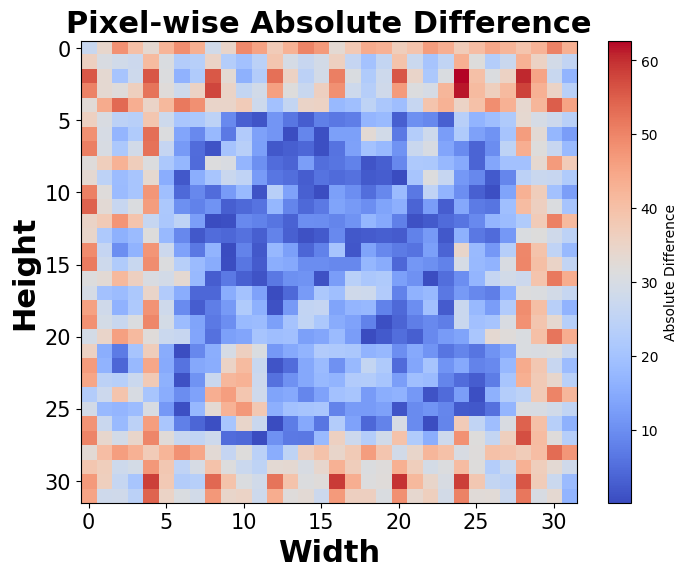

In [ ]:
font_size = 15
font = {'weight': 'bold', 'size': 22}


# Calculate pixel-wise absolute difference
pixel_diff = np.abs(Bnchmrk_Enc_Syn1 - Ovrfrng_Enc_Syn1)

# Plot the pixel-wise difference
plt.figure(figsize=(8, 6))
plt.imshow(pixel_diff, cmap='coolwarm', aspect='auto')
plt.title('Pixel-wise Absolute Difference', fontdict=font)
plt.colorbar(label='Absolute Difference')
plt.xlabel('Width', fontdict=font)
plt.ylabel('Height', fontdict=font)
# plt.xticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))
# plt.yticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))

plt.tick_params(labelsize=font_size)
plt.show()


### Histogram Analysis:

Ovrfrng_Enc_Syn1.flatten().shape =  (1024,)


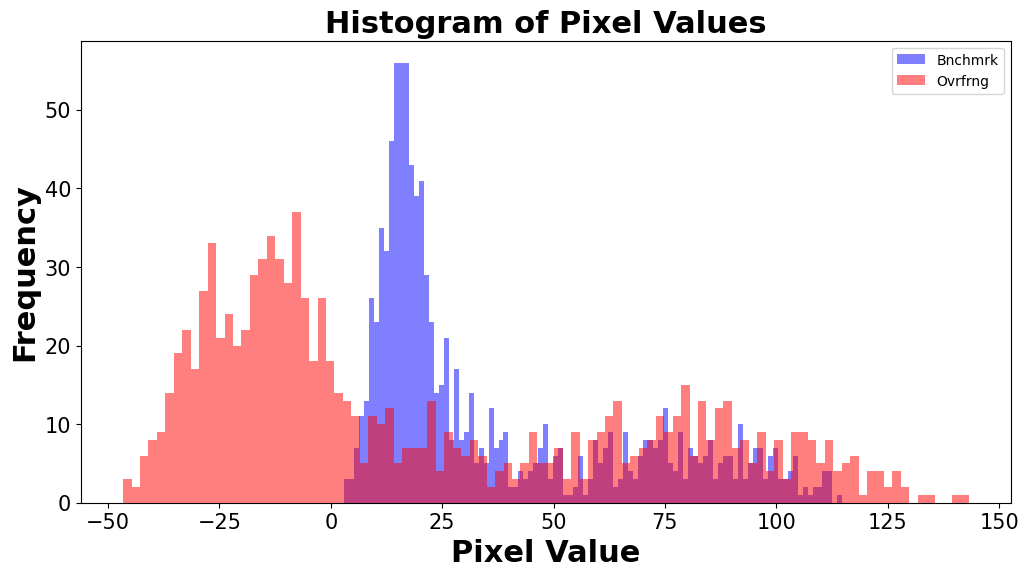

In [ ]:
font_size = 15
font = {'weight': 'bold', 'size': 22}

print("Ovrfrng_Enc_Syn1.flatten().shape = ",Ovrfrng_Enc_Syn1.flatten().shape)

# Plot histograms of pixel values
plt.figure(figsize=(12, 6))
plt.hist(Bnchmrk_Enc_Syn1.flatten(), bins=100, alpha=0.5, label='Bnchmrk', color='blue')
plt.hist(Ovrfrng_Enc_Syn1.flatten(), bins=100, alpha=0.5, label='Ovrfrng', color='red')
plt.title('Histogram of Pixel Values', fontdict=font)
plt.xlabel('Pixel Value', fontdict=font)
plt.ylabel('Frequency', fontdict=font)
plt.tick_params(labelsize=font_size)

plt.legend()
plt.show()



# -----------------------------------------------   KDE ----------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming Bnchmrk_Enc_Syn1 and Ovrfrng_Enc_Syn1 are your data arrays

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with two subplots (side by side)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot KDE for Bnchmrk state
sns.kdeplot(Bnchmrk_Enc_Syn1.flatten(), ax=axs[0], color='blue', label='Bnchmrk', shade=True)
axs[0].set_title('KDE Plot (Bnchmrk)', fontsize=15)
axs[0].set_xlabel('Pixel Value', fontsize=12)
axs[0].set_ylabel('Density', fontsize=12)

# Plot KDE for Ovrfrng state
sns.kdeplot(Ovrfrng_Enc_Syn1.flatten(), ax=axs[1], color='red', label='Ovrfrng', shade=True)
axs[1].set_title('KDE Plot (Ovrfrng)', fontsize=15)
axs[1].set_xlabel('Pixel Value', fontsize=12)
axs[1].set_ylabel('Density', fontsize=12)
axs[0].legend()
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### Region of Interest (ROI) Analysis:


In [ ]:
Bnchmrk_Enc_Syn1.shape

()

Average Pixel Value in Bnchmrk ROI: 37.459590911865234
Average Pixel Value in Ovrfrng ROI: 22.284772872924805


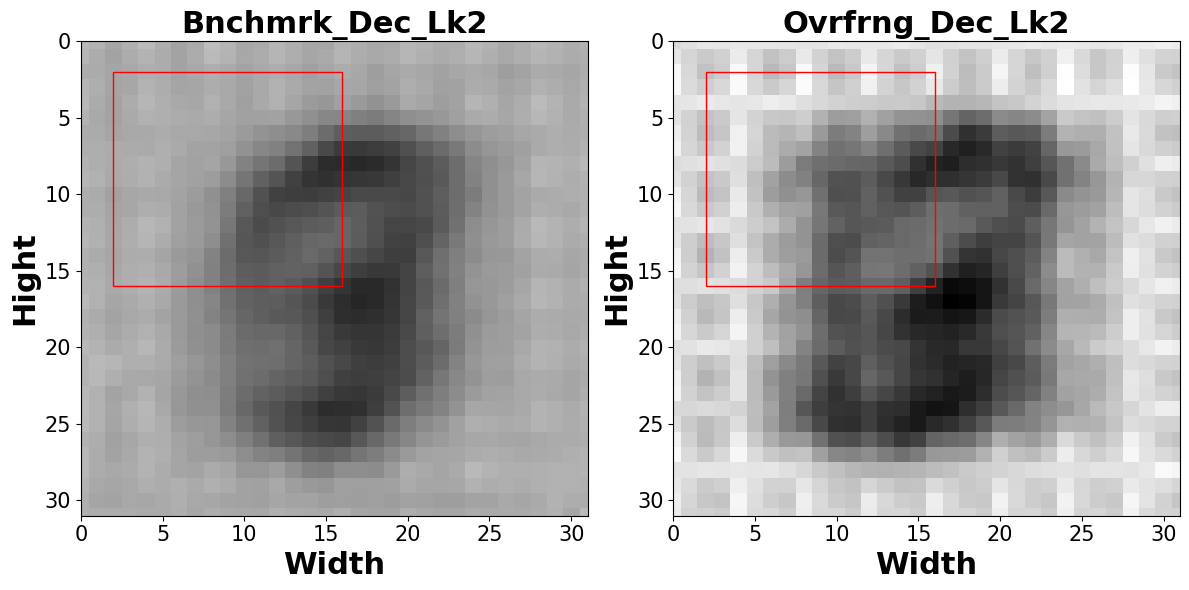

In [ ]:
font_size = 15
font = {'weight': 'bold', 'size': 22}

# Define ROI coordinates (example: rectangular ROI)
roi_x = slice(2, 16)  # Define the x-axis range
roi_y = slice(2, 16)  # Define the y-axis range

# Extract ROIs from both states
roi_benchmark = Bnchmrk_Enc_Syn1[roi_x, roi_y]
roi_ovrfrng = Ovrfrng_Enc_Syn1[roi_x, roi_y]

# Calculate average pixel values within ROIs
avg_pixel_benchmark = np.mean(roi_benchmark)
avg_pixel_ovrfrng = np.mean(roi_ovrfrng)

# Print the average values within ROIs
print(f'Average Pixel Value in Bnchmrk ROI: {avg_pixel_benchmark}')
print(f'Average Pixel Value in Ovrfrng ROI: {avg_pixel_ovrfrng}')

# Visualize the ROIs within the original plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(Bnchmrk_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto')
plt.title(f'Bnchmrk_{hook_names[L]}', fontdict=font)
plt.xlim(0, Bnchmrk_Enc_Syn1.shape[1]-1)
plt.ylim(Bnchmrk_Enc_Syn1.shape[0]-1, 0)
plt.gca().add_patch(plt.Rectangle((roi_x.start, roi_y.start), roi_x.stop - roi_x.start, roi_y.stop - roi_y.start, fill=False, color='red'))
plt.tick_params(labelsize=font_size)
plt.xlabel('Width', fontweight="bold", fontdict=font)
plt.ylabel('Hight', fontweight="bold", fontdict=font)

plt.subplot(1, 2, 2)
plt.imshow(Ovrfrng_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto')
plt.title(f'Ovrfrng_{hook_names[L]}', fontdict=font)
plt.xlim(0, Ovrfrng_Enc_Syn1.shape[1]-1)
plt.ylim(Ovrfrng_Enc_Syn1.shape[0]-1, 0)
plt.gca().add_patch(plt.Rectangle((roi_x.start, roi_y.start), roi_x.stop - roi_x.start, roi_y.stop - roi_y.start, fill=False, color='red'))
plt.tick_params(labelsize=font_size)
plt.xlabel('Width', fontweight="bold", fontdict=font)
plt.ylabel('Hight', fontweight="bold", fontdict=font)

plt.tight_layout()
plt.show()


The observation that the average pixel value of the "Bnchmrk" state is higher than that of the "Ovrfrng" state in your analysis can be justified based on the characteristics of the over-firing state and the effect of increased conductivity in a spiking neural network (SNN) leaky neuron model. Here's a justification for this phenomenon:

1. **Higher Activation in Bnchmrk State**: In the "Bnchmrk" state, the SNN leaky neuron model may not be operating in an over-firing mode. It could be closer to a typical operating point where neurons have moderate firing rates. As a result, the activation levels across the neural network may be higher in the "Bnchmrk" state compared to the "Ovrfrng" state.

2. **Effect of Increased Conductivity**: When you increase the conductivity of neurons in the SNN leaky neuron model, it generally makes the neurons more excitable. This means they are more likely to fire and produce spikes in response to input. However, it also means that they might not reach as high activation levels because they are firing more frequently and resetting their membrane potentials faster.

3. **Impact on Pixel Values**: In your analysis, each pixel value represents the activation or spike rate of a neuron in the SNN. In the "Bnchmrk" state, since neurons might not be firing as frequently, they have more time to accumulate charge and, therefore, reach higher activation levels, resulting in higher pixel values in the visualization.

4. **Contrast with "Ovrfrng" State**: In the "Ovrfrng" state, where neurons are more prone to over-firing due to increased conductivity, they may not reach the same high activation levels because they are firing more often, resetting faster, and possibly experiencing refractory periods. This could lead to lower average pixel values in the visualization.

To summarize, the difference in pixel values between the "Bnchmrk" and "Ovrfrng" states can be attributed to the dynamic behavior of neurons in response to increased conductivity. "Bnchmrk" neurons have more time to accumulate charge and reach higher activation levels, while "Ovrfrng" neurons might fire more frequently but reset faster, resulting in lower average pixel values. This observation is consistent with the expected effects of increased conductivity on neuron behavior in a spiking neural network.

### For Latent Space with size (250, 32):

shape of Bnchmrk_Enc_Lk2 torch.Size([250, 32])
shape of Bnchmrk[0,:]_Enc_Lk2 torch.Size([32])
shape of Ovrfrng_Enc_Lk2 torch.Size([250, 32])


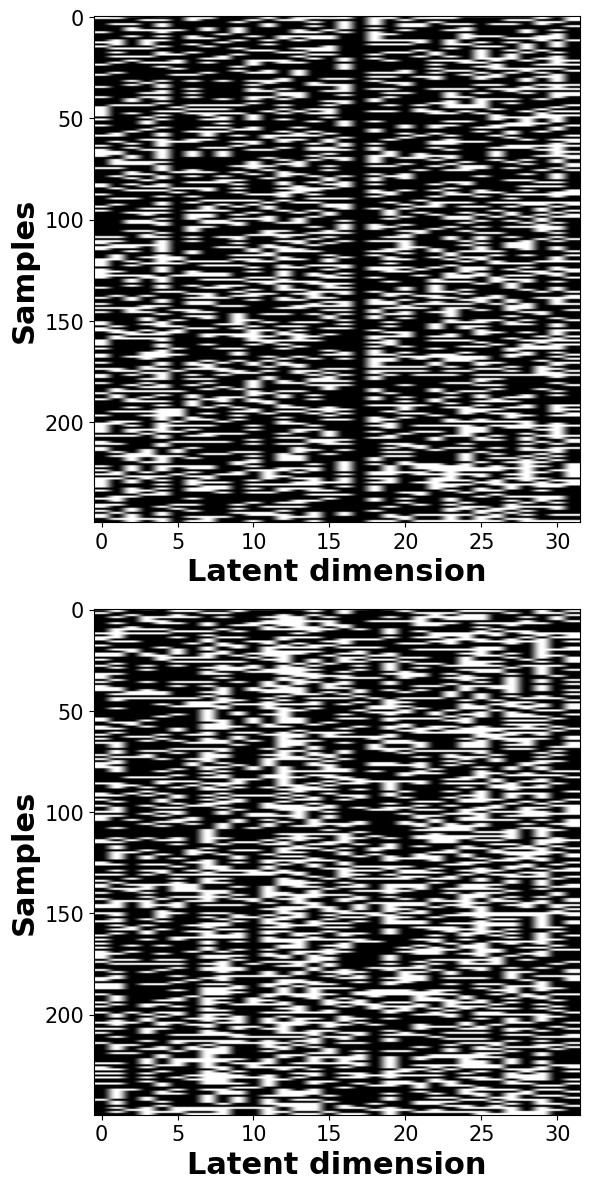

In [ ]:

# ----------------loading data to two files:
L=3
Bnchmrk_Enc_Lk2= epoch_activations[48][hook_names[L]][0]
Ovrfrng_Enc_Lk2= epoch_activations_OverFiring[48][hook_names[L]][0]
print(f"shape of Bnchmrk_{hook_names[L]}", Bnchmrk_Enc_Lk2.shape)
print(f"shape of Bnchmrk[0,:]_{hook_names[L]}", Bnchmrk_Enc_Lk2[0,:].shape)
print(f"shape of Ovrfrng_{hook_names[L]}", Ovrfrng_Enc_Lk2.shape)



# -------------------------------------------------------------------


fig, axs = plt.subplots(2, 1, figsize=(6, 12))
font_size = 15
font = {'weight': 'bold', 'size': 22}


# for Layer (250,32):
Bnchmrk_Enc_Lk2 = Bnchmrk_Enc_Lk2.cpu().numpy()
Ovrfrng_Enc_Lk2 = Ovrfrng_Enc_Lk2.cpu().numpy()

# Plot the spike rates for "activation["Enc_syn1"]"
# axs[0].imshow(Bnchmrk_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto')
# axs[0].imshow(Bnchmrk_Enc_Lk2[1:2,:], cmap='binary', aspect='auto')   #   -------------------------- just one sample
axs[0].imshow(Bnchmrk_Enc_Lk2[:,:], cmap='binary', aspect='auto')
# axs[0].set_title(f'Bnchmrk_{hook_names[L]}', fontdict=font)
axs[0].set_xlabel('Latent dimension', fontweight="bold", fontdict=font)
axs[0].set_ylabel('Samples', fontweight="bold", fontdict=font)
axs[0].tick_params(labelsize=font_size)
# axs[0].set_xticks(np.arange(Ovrfrng_Enc_Lk2.shape[0]))
# axs[0].set_yticks(np.arange(Ovrfrng_Enc_Lk2.shape[0]))


# Plot the spike rates for "activation["Enc_syn1_ovrfrng"]"
# axs[1].imshow(Ovrfrng_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto')
# axs[1].imshow(Ovrfrng_Enc_Lk2[1:2,:], cmap='binary', aspect='auto')      #   -------------------------- just one sample
axs[1].imshow(Ovrfrng_Enc_Lk2[:,:], cmap='binary', aspect='auto')
# axs[1].set_title(f'Ovrfrng_{hook_names[L]}', fontdict=font)
axs[1].set_xlabel('Latent dimension', fontweight="bold", fontdict=font)
axs[1].set_ylabel('Samples', fontweight="bold", fontdict=font)
axs[1].tick_params(labelsize=font_size)
# axs[1].set_xticks(np.arange(Ovrfrng_Enc_Lk2.shape[0]))
# axs[1].set_yticks(np.arange(Ovrfrng_Enc_Lk2.shape[0]))

plt.tight_layout()
plt.show()



### the latent dimensions represent abstract features or patterns that the model has learned to capture from the input data. Each latent dimension can be thought of as encoding a specific characteristic or aspect of the input. Intuitively, these dimensions aim to represent relevant information in a more compact and abstract form.

In [ ]:

# # Function to plot distribution
# def plot_distribution(latent_space_data, scenario_name):
#     plt.figure(figsize=(10, 6))
#     plt.title(f"Latent Space Distribution - {scenario_name}")
#     plt.bar(range(latent_space_data.shape[1]), np.mean(latent_space_data, axis=0), color='blue', alpha=0.7, label='1s')
#     # plt.bar(range(latent_space_data.shape[1]), 1 - np.mean(latent_space_data, axis=0), bottom=np.mean(latent_space_data, axis=0), color='red', alpha=0.7, label='0s')
#     plt.xlabel('Latent Dimension')
#     plt.ylabel('Proportion')
#     # plt.legend()
#     plt.show()

# # Plot distribution for benchmark scenario
# plot_distribution(Bnchmrk_Enc_Lk2, "Benchmark")

# # Plot distribution for overfiring scenario
# plot_distribution(Ovrfrng_Enc_Lk2, "Overfiring")


# Plot the distribution for Benchmark scenario
plt.figure(figsize=(10, 5))
plt.bar(range(Bnchmrk_Enc_Lk2.shape[1]), np.mean(Bnchmrk_Enc_Lk2, axis=0), color='blue', label='Benchmark')
plt.xlabel('Latent dimension')
plt.ylabel('Probability (mean)')
plt.title('Distribution of Latent Space (Benchmark)')
plt.legend()
plt.show()

# Plot the distribution for Overfiring scenario
plt.figure(figsize=(10, 5))
plt.bar(range(Ovrfrng_Enc_Lk2.shape[1]), np.mean(Ovrfrng_Enc_Lk2, axis=0), color='orange', label='Overfiring')
plt.xlabel('Latent dimension')
plt.ylabel('Probability (mean)')
plt.title('Distribution of Latent Space (Overfiring)')
plt.legend()
plt.show()

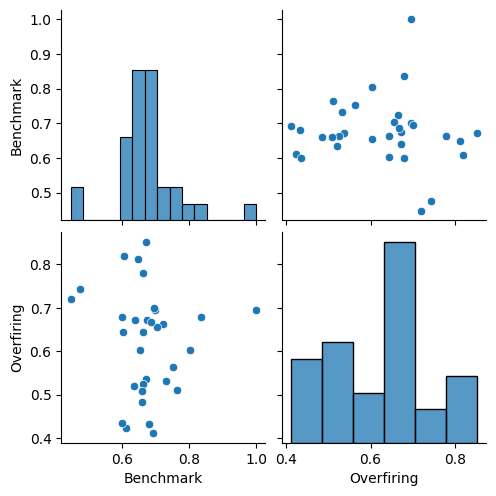

In [ ]:
# Summary statistics for Benchmark scenario
# benchmark_stats = pd.DataFrame(Bnchmrk_Enc_Lk2).describe()
# print("benchmark_stats:" , benchmark_stats)

# # Summary statistics for Overfiring scenario
# overfiring_stats = pd.DataFrame(Ovrfrng_Enc_Lk2).describe()
# print('overfiring_stats', overfiring_stats)

# print('----------------------------------------------')


# Pairwise scatter plots for Benchmark vs. Overfiring
sns.pairplot(pd.DataFrame({'Benchmark': Bnchmrk_Enc_Lk2.mean(axis=0), 'Overfiring': Ovrfrng_Enc_Lk2.mean(axis=0)}))
plt.show()


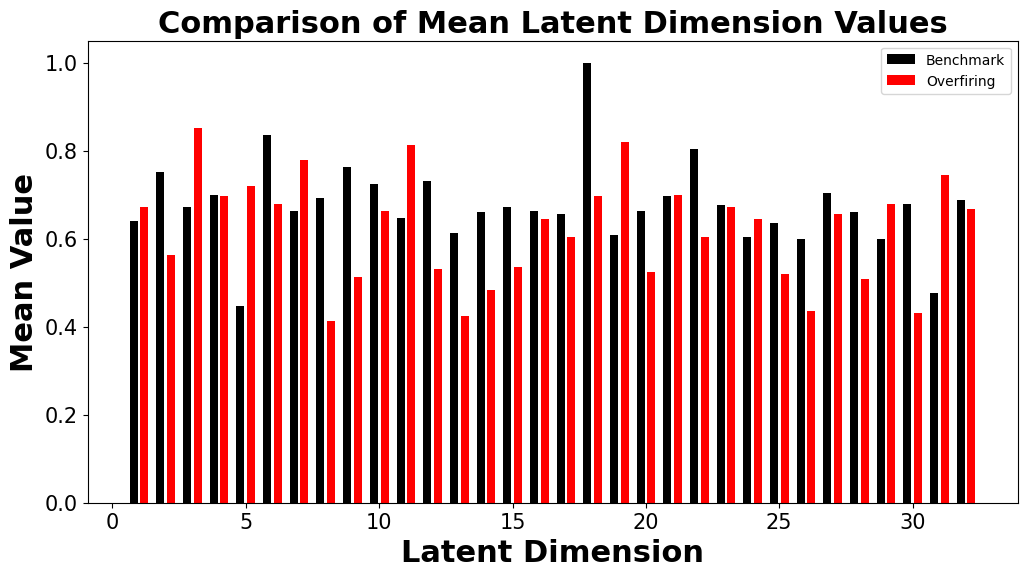

Mean Difference Bnchmrk-Ovrfrng : 0.054375000298023224
T-statistic: 1.989957834968805, p-value: 0.05101014409404372


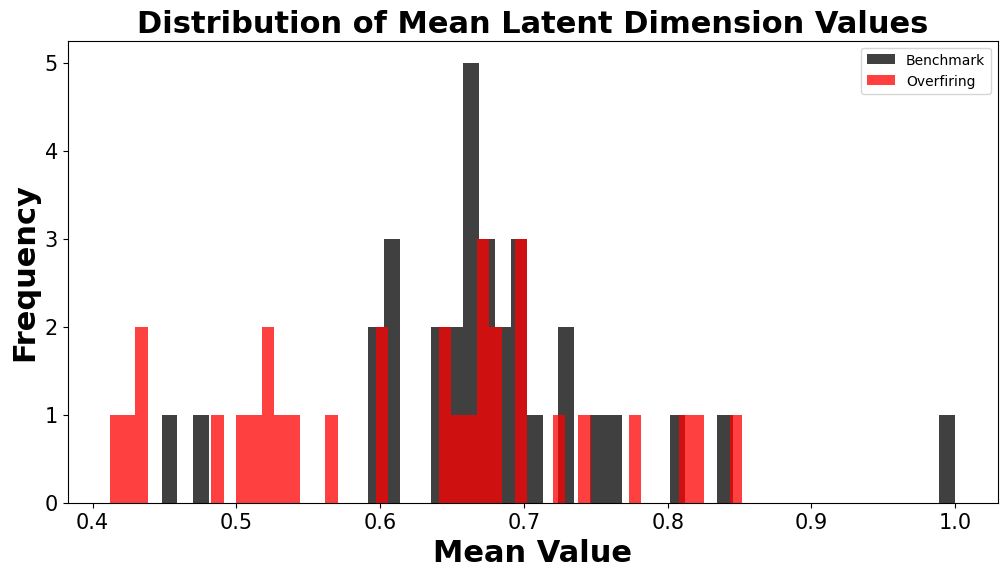

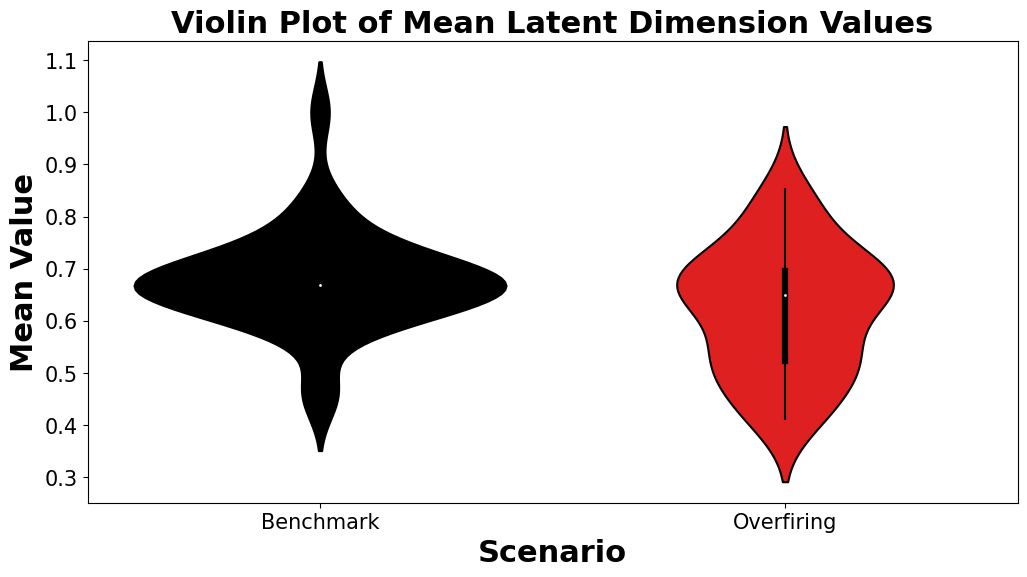

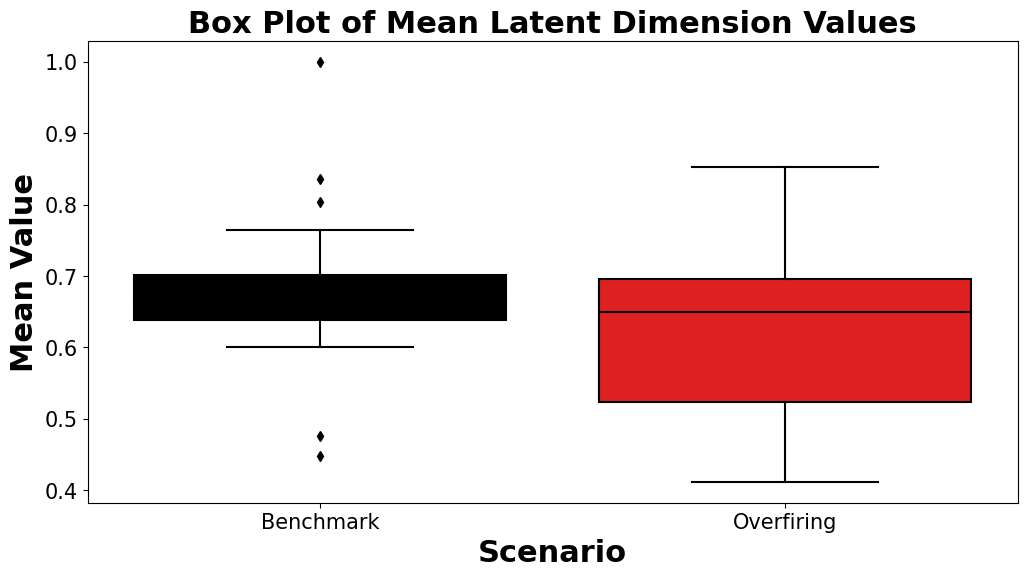

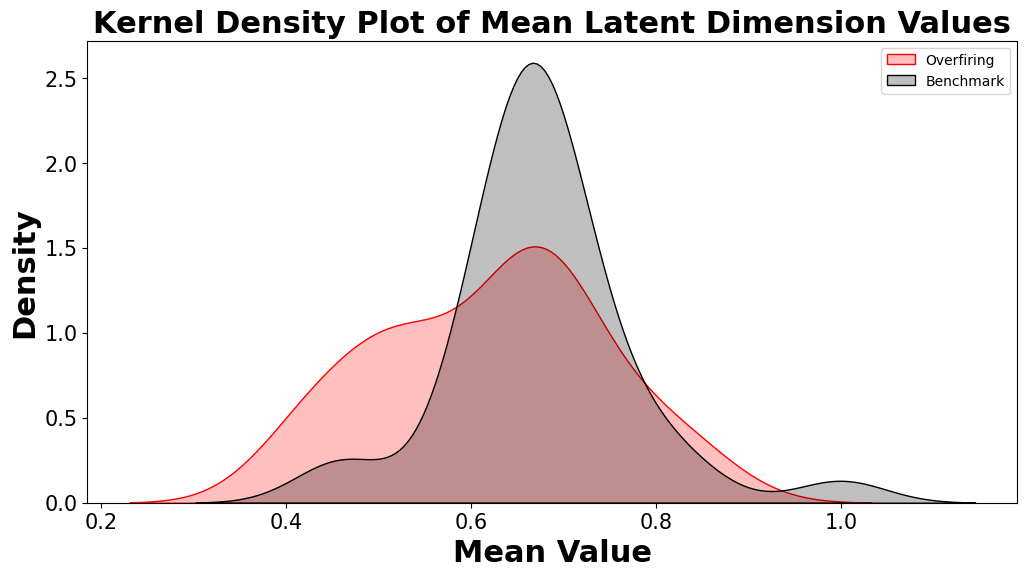

In [ ]:
# print('Bnchmrk_Enc_Lk2.mean(axis=0)',Bnchmrk_Enc_Lk2.mean(axis=0))
# print('----')
# print('Ovrfrng_Enc_Lk2.mean(axis=0)', Ovrfrng_Enc_Lk2.mean(axis=0))

import matplotlib.pyplot as plt
import numpy as np

latent_dimensions = np.arange(1, Bnchmrk_Enc_Lk2.shape[1] + 1)

plt.figure(figsize=(12, 6))
plt.bar(latent_dimensions - 0.2, Bnchmrk_Enc_Lk2.mean(axis=0), width=0.3, label='Benchmark', color='black')
plt.bar(latent_dimensions + 0.2, Ovrfrng_Enc_Lk2.mean(axis=0), width=0.3, label='Overfiring', color='red')
plt.xlabel('Latent Dimension', fontdict=font)
plt.xticks(np.arange(Bnchmrk_Enc_Lk2.shape[0]))
plt.ylabel('Mean Value', fontdict=font)
plt.title('Comparison of Mean Latent Dimension Values', fontdict=font)
plt.tick_params(labelsize=font_size)
plt.legend()
plt.show()

# # -----------------------------------------------------------------------
from scipy.stats import ttest_ind

# Statistical comparison
mean_diff = np.mean(Bnchmrk_Enc_Lk2.mean(axis=0) - Ovrfrng_Enc_Lk2.mean(axis=0))
t_stat, p_value = ttest_ind(Bnchmrk_Enc_Lk2.mean(axis=0), Ovrfrng_Enc_Lk2.mean(axis=0))

print(f"Mean Difference Bnchmrk-Ovrfrng : {mean_diff}")
print(f"T-statistic: {t_stat}, p-value: {p_value}")

# # ----------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.hist(Bnchmrk_Enc_Lk2.mean(axis=0), alpha=0.75, label='Benchmark', bins=50, color='black')
plt.hist(Ovrfrng_Enc_Lk2.mean(axis=0), alpha=0.75, label='Overfiring', bins=50, color='red')
plt.xlabel('Mean Value', fontdict=font)
plt.ylabel('Frequency', fontdict=font)
plt.title('Distribution of Mean Latent Dimension Values', fontdict=font)
plt.tick_params(labelsize=font_size)
plt.legend()
plt.show()
# ///////////////////////////////////
# Violin Plot:
# A combination of a box plot and kernel density plot, offering insights into the distribution and concentration of mean values.
plt.figure(figsize=(12, 6))
sns.violinplot(data=[Bnchmrk_Enc_Lk2.mean(axis=0), Ovrfrng_Enc_Lk2.mean(axis=0)], palette=['black', 'red'])
plt.xlabel('Scenario', fontdict=font)
plt.ylabel('Mean Value', fontdict=font)
plt.title('Violin Plot of Mean Latent Dimension Values', fontdict=font)
plt.tick_params(labelsize=font_size)
plt.xticks([0, 1], ['Benchmark', 'Overfiring'])
plt.show()
# /////////////////////////////////////////////////////////////
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=[Bnchmrk_Enc_Lk2.mean(axis=0), Ovrfrng_Enc_Lk2.mean(axis=0)], palette=['black', 'red'])
plt.xlabel('Scenario', fontdict=font)
plt.ylabel('Mean Value', fontdict=font)
plt.title('Box Plot of Mean Latent Dimension Values', fontdict=font)
plt.tick_params(labelsize=font_size)
plt.xticks([0, 1], ['Benchmark', 'Overfiring'])
plt.show()

# ----------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the data into a DataFrame
data = {
    'Benchmark': Bnchmrk_Enc_Lk2.mean(axis=0),
    'Overfiring': Ovrfrng_Enc_Lk2.mean(axis=0)
}
df = pd.DataFrame(data)

# Create a Kernel Density Plot
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, fill=True, palette=['black', 'red'])
plt.xlabel('Mean Value', fontdict=font)
plt.ylabel('Density', fontdict=font)
plt.title('Kernel Density Plot of Mean Latent Dimension Values', fontdict=font)
plt.tick_params(labelsize=font_size)
plt.legend(['Overfiring', 'Benchmark'])
plt.show()


### One Sample

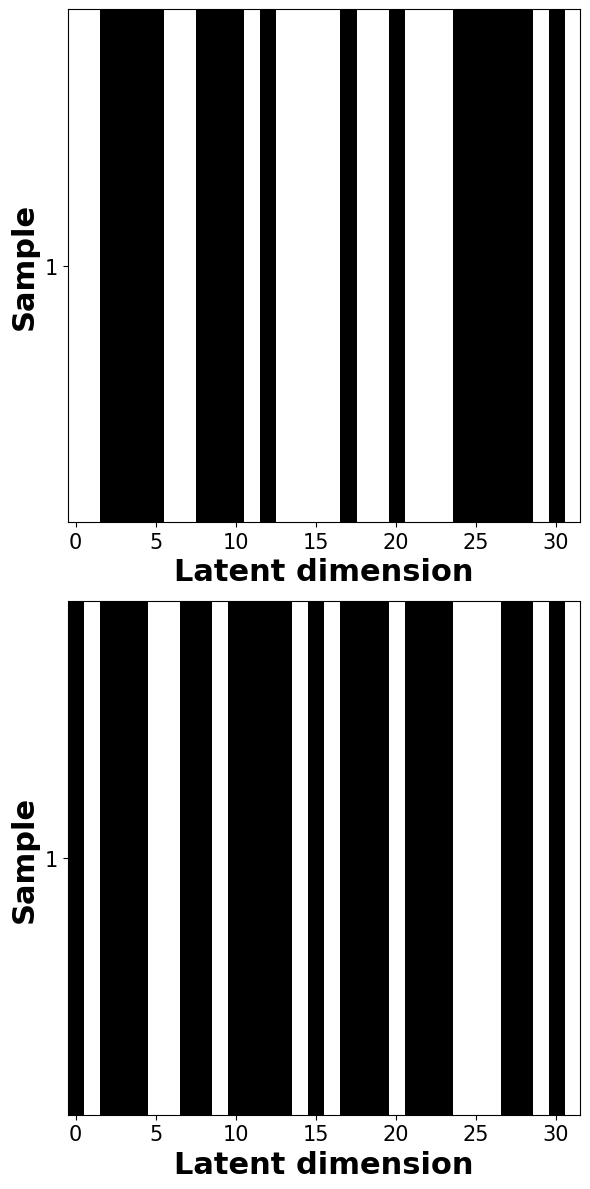

In [ ]:
import matplotlib.pyplot as plt

# Modify the Y-axis ticks to show only 0
y_ticks = [0]
y_labels = [1]

fig, axs = plt.subplots(2, 1, figsize=(6, 12))
font_size = 15
font = {'weight': 'bold', 'size': 22}

# Your code for loading data here

# Plot the spike rates for "activation["Enc_syn1"]"
axs[0].imshow(Bnchmrk_Enc_Lk2[1:2,:], cmap='binary', aspect='auto')
axs[0].set_xlabel('Latent dimension', fontweight="bold", fontdict=font)
axs[0].set_ylabel('Sample', fontweight="bold", fontdict=font)
axs[0].set_yticks(y_ticks)
axs[0].set_yticklabels(y_labels)
axs[0].tick_params(labelsize=font_size)

# Plot the spike rates for "activation["Enc_syn1_ovrfrng"]"
axs[1].imshow(Ovrfrng_Enc_Lk2[1:2,:], cmap='binary', aspect='auto')
axs[1].set_xlabel('Latent dimension', fontweight="bold", fontdict=font)
axs[1].set_ylabel('Sample', fontweight="bold", fontdict=font)
axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels(y_labels)
axs[1].tick_params(labelsize=font_size)

plt.tight_layout()
plt.show()


In [ ]:
# Bnchmrk_Enc_Lk2.reshape(Bnchmrk_Enc_Lk2[0],-1)

# Bnchmrk_Enc_Lk2.flatten().shape        # (8000, )


KL Divergence: 45962.08984375


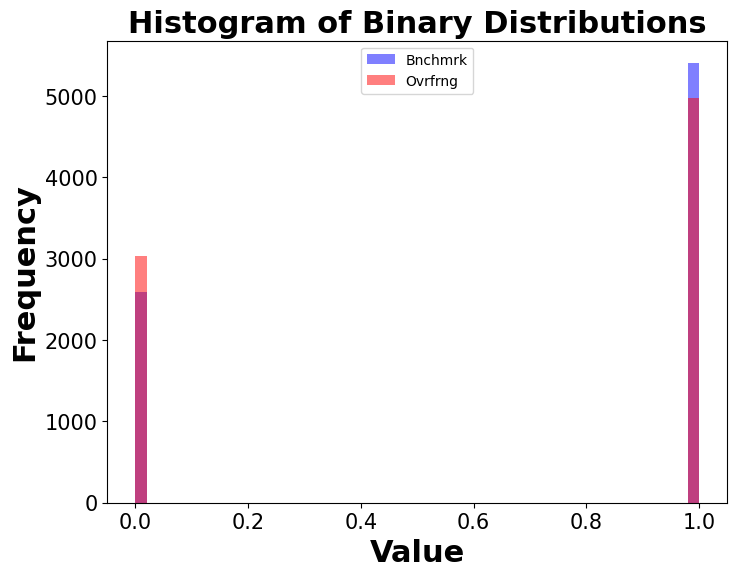

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kl_div

font_size = 15
font = {'weight': 'bold', 'size': 22}

# Flatten the tensors to 1D arrays
# flat_bench = Bnchmrk_Enc_Lk2.view(-1).cpu().numpy()
# flat_ovrfrng = Ovrfrng_Enc_Lk2.view(-1).cpu().numpy()
flat_bench = Bnchmrk_Enc_Lk2.flatten()
flat_ovrfrng = Ovrfrng_Enc_Lk2.flatten()

# Calculate KL Divergence
epsilon = 1e-10
flat_bench = flat_bench + epsilon
flat_ovrfrng = flat_ovrfrng + epsilon


kl_divergence = np.sum(kl_div(flat_bench, flat_ovrfrng))
print(f"KL Divergence: {kl_divergence}")

# Visualize the KL Divergence using a histogram
plt.figure(figsize=(8, 6))
plt.hist(flat_bench, bins=50, alpha=0.5, label='Bnchmrk', color='blue')
plt.hist(flat_ovrfrng, bins=50, alpha=0.5, label='Ovrfrng', color='red')
plt.xlabel('Value', fontdict=font)
plt.ylabel('Frequency', fontdict=font)
plt.title('Histogram of Binary Distributions', fontdict=font)
plt.legend(loc='upper center')
plt.tick_params(labelsize=font_size)

plt.show()

## Entropy

Entropy assesses the uncertainty within a single dataset, while mutual information measures the shared information or dependency between two datasets. The range of values for entropy and mutual information depends on the data and the computation method, but generally, entropy ranges from 0 to 1 for binary data, and mutual information ranges from 0 to a positive maximum value.

Higher entropy means greater uncertainty or randomness, while lower entropy means more predictability or order. It is a measure of the average information content in the data.

<ipython-input-22-58365d4f74a1>:16: RuntimeWarning: divide by zero encountered in log2
  return -p * np.log2(p) - (1 - p) * np.log2(1 - p)
<ipython-input-22-58365d4f74a1>:16: RuntimeWarning: invalid value encountered in multiply
  return -p * np.log2(p) - (1 - p) * np.log2(1 - p)


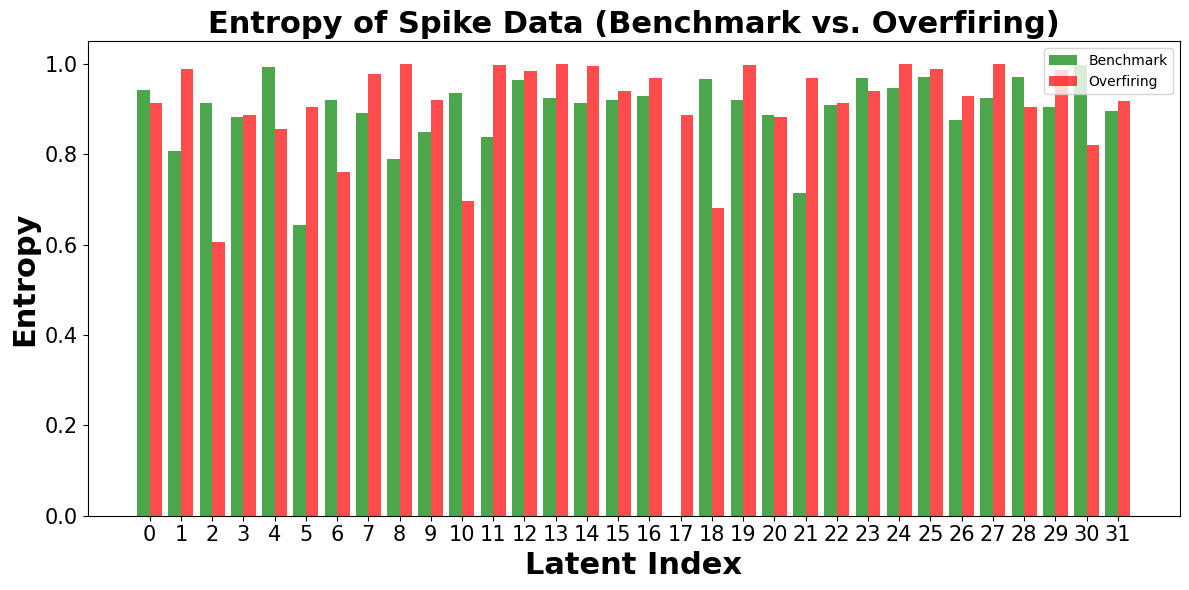

<ipython-input-22-58365d4f74a1>:57: RuntimeWarning: divide by zero encountered in log2
  return -p * np.log2(p) - (1 - p) * np.log2(1 - p)
<ipython-input-22-58365d4f74a1>:57: RuntimeWarning: invalid value encountered in multiply
  return -p * np.log2(p) - (1 - p) * np.log2(1 - p)


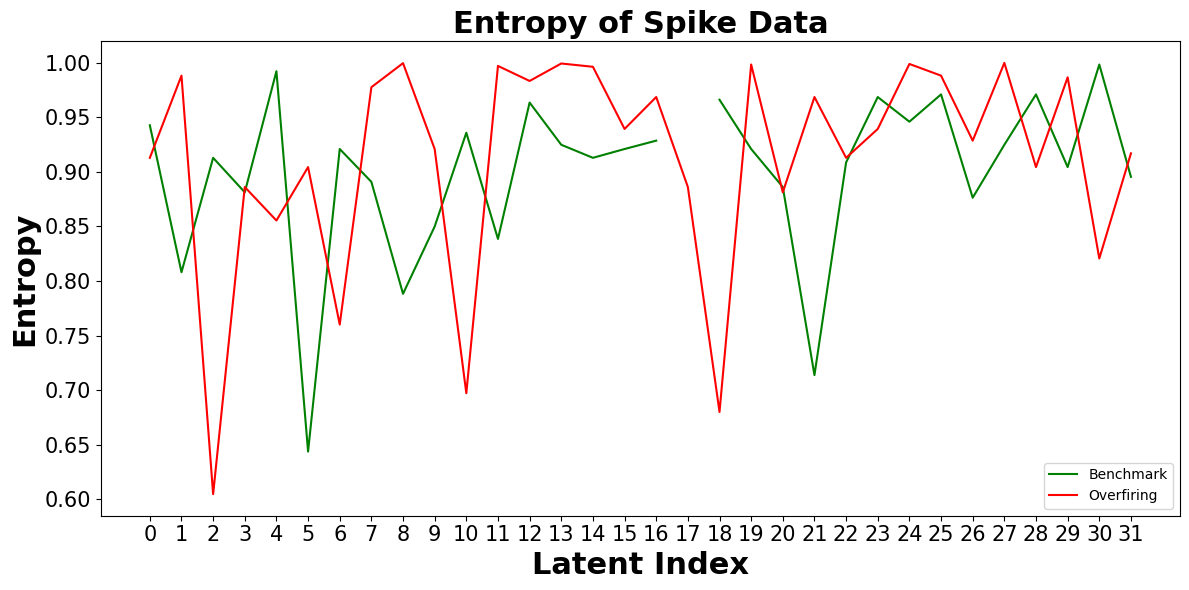

<ipython-input-22-58365d4f74a1>:98: RuntimeWarning: divide by zero encountered in log2
  return -p * np.log2(p) - (1 - p) * np.log2(1 - p)
<ipython-input-22-58365d4f74a1>:98: RuntimeWarning: invalid value encountered in multiply
  return -p * np.log2(p) - (1 - p) * np.log2(1 - p)
<ipython-input-22-58365d4f74a1>:108: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(entropies_benchmark, color='g', label='Benchmark', shade=True)
<ipython-input-22-58365d4f74a1>:109: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(entropies_overfiring, color='r', label='Overfiring', shade=True)


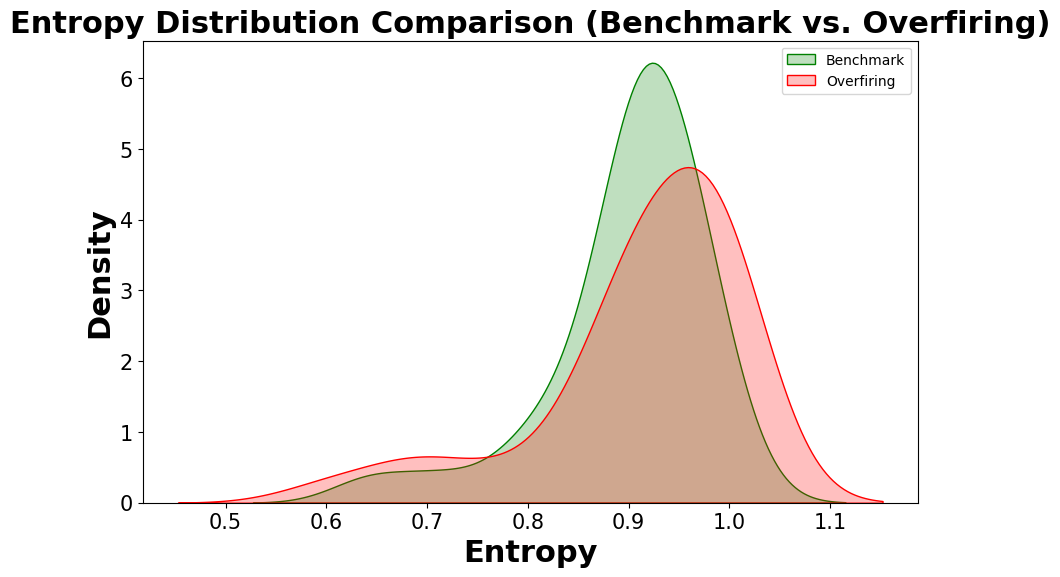

In [ ]:
font_size = 15
font = {'weight': 'bold', 'size': 22}

# # Assuming spike_data contains both Bnchmrk_Enc_Lk2 and Ovrfrng_Enc_Lk2
spike_data_benchmark = Bnchmrk_Enc_Lk2
spike_data_overfiring = Ovrfrng_Enc_Lk2

# # Calculate the probability distribution for each neuron for benchmark data
probabilities_benchmark = np.mean(spike_data_benchmark, axis=0)

# Calculate the probability distribution for each neuron for overfiring data
probabilities_overfiring = np.mean(spike_data_overfiring, axis=0)

# Compute the entropy for each neuron for benchmark data
def entropy(p):
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

entropies_benchmark = entropy(probabilities_benchmark)

# Compute the entropy for each neuron for overfiring data
entropies_overfiring = entropy(probabilities_overfiring)

# Create a list of indices for the neurons
indices = range(32)

# Visualize the entropies for both benchmark and overfiring data in one grouped bar chart
plt.figure(figsize=(12, 6))
width = 0.4  # Width of each bar

plt.bar(indices, entropies_benchmark, width=width, color='g', alpha=0.7, label='Benchmark')
plt.bar([i + width for i in indices], entropies_overfiring, width=width, color='r', alpha=0.7, label='Overfiring')
plt.xlabel('Latent Index', fontdict=font)
plt.ylabel('Entropy', fontdict=font)
plt.title('Entropy of Spike Data (Benchmark vs. Overfiring)', fontdict=font)
plt.xticks([i + width / 2 for i in indices], indices)
plt.legend(loc='upper right')
plt.tick_params(labelsize=font_size)

plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# Assuming spike_data contains both Bnchmrk_Enc_Lk2 and Ovrfrng_Enc_Lk2
spike_data_benchmark = Bnchmrk_Enc_Lk2
spike_data_overfiring = Ovrfrng_Enc_Lk2

# Calculate the probability distribution for each neuron for benchmark data
probabilities_benchmark = np.mean(spike_data_benchmark, axis=0)

# Calculate the probability distribution for each neuron for overfiring data
probabilities_overfiring = np.mean(spike_data_overfiring, axis=0)

# Compute the entropy for each neuron for benchmark data
def entropy(p):
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

entropies_benchmark = entropy(probabilities_benchmark)

# Compute the entropy for each neuron for overfiring data
entropies_overfiring = entropy(probabilities_overfiring)

# Visualize the entropy values for both benchmark and overfiring data in one figure
plt.figure(figsize=(12, 6))

plt.plot(range(32), entropies_benchmark, label='Benchmark', color='g')
plt.plot(range(32), entropies_overfiring, label='Overfiring', color='r')

plt.xlabel('Latent Index', fontdict=font)
plt.ylabel('Entropy', fontdict=font)
plt.title('Entropy of Spike Data', fontdict=font)
plt.xticks(range(32))
plt.tick_params(labelsize=font_size)

plt.legend()

plt.tight_layout()
plt.show()


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming spike_data contains both Bnchmrk_Enc_Lk2 and Ovrfrng_Enc_Lk2
spike_data_benchmark = Bnchmrk_Enc_Lk2
spike_data_overfiring = Ovrfrng_Enc_Lk2

# Calculate the probability distribution for each neuron for benchmark data
probabilities_benchmark = np.mean(spike_data_benchmark, axis=0)

# Calculate the probability distribution for each neuron for overfiring data
probabilities_overfiring = np.mean(spike_data_overfiring, axis=0)

# Compute the entropy for each neuron for benchmark data
def entropy(p):
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

entropies_benchmark = entropy(probabilities_benchmark)

# Compute the entropy for each neuron for overfiring data
entropies_overfiring = entropy(probabilities_overfiring)

# Create a KDE plot to compare the distributions
plt.figure(figsize=(10, 6))

sns.kdeplot(entropies_benchmark, color='g', label='Benchmark', shade=True)
sns.kdeplot(entropies_overfiring, color='r', label='Overfiring', shade=True)

plt.xlabel('Entropy', fontdict=font)
plt.ylabel('Density', fontdict=font)
plt.title('Entropy Distribution Comparison (Benchmark vs. Overfiring)', fontdict=font)
plt.tick_params(labelsize=font_size)
plt.legend()
plt.show()


## Mutual information

Mutual information values can range from 0 (no shared information or independence) to a positive maximum value (perfect dependence or complete shared information)


Mutual Information: 0.0002132447435702371


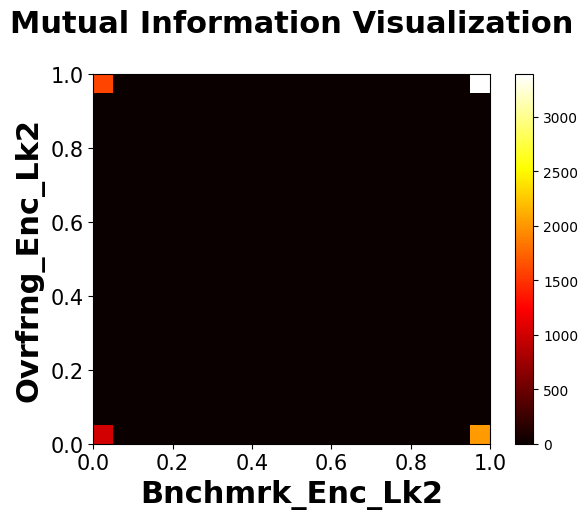

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

font_size = 15
font = {'weight': 'bold', 'size': 22}

# Generate synthetic data (replace with your actual data)
np.random.seed(0)
data1 = Bnchmrk_Enc_Lk2
data2 = Ovrfrng_Enc_Lk2

# Compute the mutual information
def mutual_information(x, y, bins=10):
    H_xy, x_edges, y_edges = np.histogram2d(x, y, bins=bins)
    H_x = np.histogram(x, bins=x_edges)[0]
    H_y = np.histogram(y, bins=y_edges)[0]

    epsilon = 1e-10  # Small epsilon value for smoothing

    p_xy = (H_xy + epsilon) / float(np.sum(H_xy) + epsilon)
    p_x = (H_x + epsilon) / float(np.sum(H_x) + epsilon)
    p_y = (H_y + epsilon) / float(np.sum(H_y) + epsilon)


    p_x[p_x == 0] = 1e-10  # Avoid division by zero
    p_y[p_y == 0] = 1e-10

    mi = np.sum(p_xy * np.log2(p_xy / (p_x[:, None] * p_y[None, :])))
    return mi

mutual_info = mutual_information(data1.flatten(), data2.flatten())

print(f"Mutual Information: {mutual_info}")

# Visualize the mutual information using a histogram
plt.hist2d(data1.flatten(), data2.flatten(), bins=20, cmap='hot')
plt.xlabel('Bnchmrk_Enc_Lk2', fontdict=font)
plt.ylabel('Ovrfrng_Enc_Lk2', fontdict=font)
plt.title('Mutual Information Visualization\n', fontdict=font)
plt.tick_params(labelsize=font_size)
plt.colorbar()
plt.show()


The synaptic changes of some neuronal maps in different layers through the learning with the MNIST dataset.
(A) The first convolutional layer becomes selective to oriented edges. (B) The second convolutional layer converges to object parts. (C) The third convolutional layer learns the object prototype and respond to whole objects.

Fig. 2 shows the preferred visual features of some neuronal maps in the first, second and third convolutional layers through the learning process. To visualize the visual feature learned by a neuron, a backward reconstruction technique is used. Indeed, the visual features in the current layer can be reconstructed as the weighted combinations of the visual features in the previous layer.


Fig. 3. Each curve shows the variation of the convergence index through the learning of a convolutional layer. The weight histogram of the first convolutional layer at some critical points during the learning is shown next to its convergence curve.

Since features are not formed at the early iterations, neurons respond to almost every pattern, therefore many of the synapses are depressed most of the times and gradually move toward 0.5, and learning convergence index peaks.
As a consequence, neurons’ activity decreases, and they start responding to a few of the patterns and not to others.

### KL div of last layer

shape of Bnchmrk_Dec_Lk2 torch.Size([250, 1, 32, 32])
shape of Ovrfrng_Dec_Lk2 torch.Size([250, 1, 32, 32])
shape of Bnchmrk_Dec_Lk2------------after sum (32, 32)
shape of Ovrfrng_Dec_Lk2------------after sum (32, 32)


<ipython-input-25-b3535b8c7db3>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Bnchmrk_Dec_Lk2 = torch.tensor(Bnchmrk_Dec_Lk2)
<ipython-input-25-b3535b8c7db3>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ovrfrng_Dec_Lk2 = torch.tensor(Ovrfrng_Dec_Lk2)


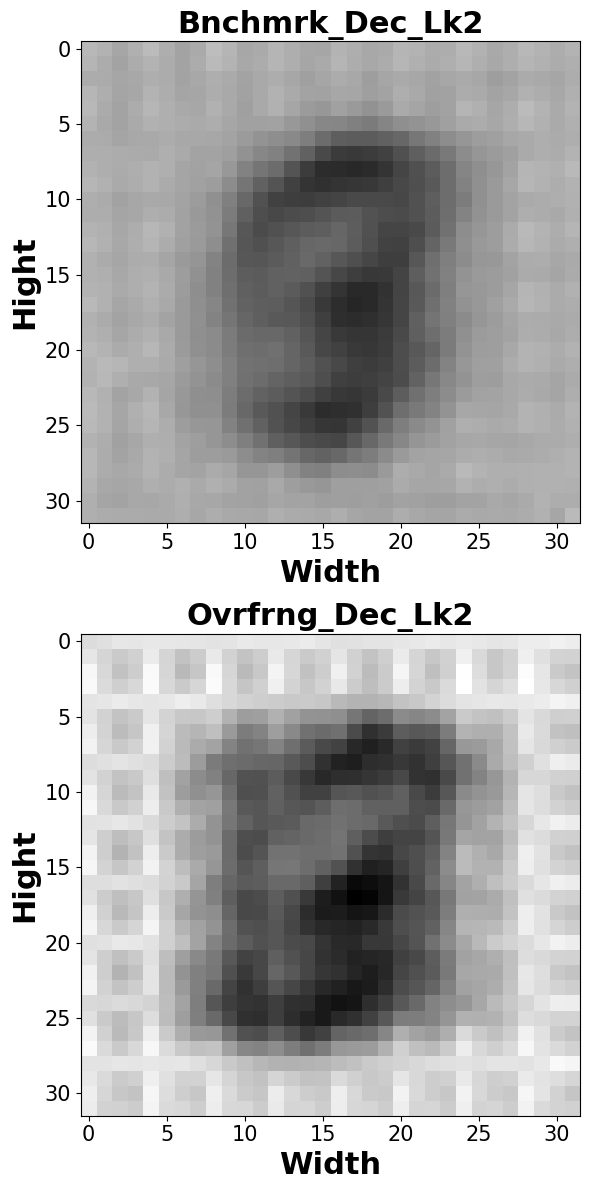

In [ ]:
# ----------------loading data to two files:
L=7
Bnchmrk_Dec_Lk2= epoch_activations[48][hook_names[L]][1]
Ovrfrng_Dec_Lk2= epoch_activations_OverFiring[48][hook_names[L]][1]
print(f"shape of Bnchmrk_{hook_names[L]}", Bnchmrk_Dec_Lk2.shape)
print(f"shape of Ovrfrng_{hook_names[L]}", Ovrfrng_Dec_Lk2.shape)



# -------------------------------------------------------------------


fig, axs = plt.subplots(2, 1, figsize=(6, 12))
font_size = 15
font = {'weight': 'bold', 'size': 22}


# Convert NumPy arrays to PyTorch tensors
Bnchmrk_Dec_Lk2 = torch.tensor(Bnchmrk_Dec_Lk2)
Ovrfrng_Dec_Lk2 = torch.tensor(Ovrfrng_Dec_Lk2)

# # for Layer (250,32):
# Bnchmrk_Enc_Syn1 = Bnchmrk_Enc_Syn1.cpu().numpy()
# Ovrfrng_Enc_Syn1 = Ovrfrng_Enc_Syn1.cpu().numpy()

Bnchmrk_Dec_Lk2 = torch.sum(Bnchmrk_Dec_Lk2, dim=(0, 1)).cpu().numpy()
Ovrfrng_Dec_Lk2 = torch.sum(Ovrfrng_Dec_Lk2, dim=(0, 1)).cpu().numpy()
print(f"shape of Bnchmrk_{hook_names[L]}------------after sum", Bnchmrk_Dec_Lk2.shape)
print(f"shape of Ovrfrng_{hook_names[L]}------------after sum", Ovrfrng_Dec_Lk2.shape)

# Calculate vmin and vmax for color scale based on the data
vmin = min(np.min(Bnchmrk_Dec_Lk2), np.min(Ovrfrng_Dec_Lk2))
vmax = max(np.max(Bnchmrk_Dec_Lk2), np.max(Ovrfrng_Dec_Lk2))

# Plot the spike rates for "activation["Enc_syn1"]"
axs[0].imshow(Bnchmrk_Dec_Lk2, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto')
# axs[0].imshow(Bnchmrk_Enc_Syn1[:,:], cmap='binary', aspect='auto')
axs[0].set_title(f'Bnchmrk_{hook_names[L]}', fontdict=font)
axs[0].set_xlabel('Width', fontweight="bold", fontdict=font)
axs[0].set_ylabel('Hight', fontweight="bold", fontdict=font)
axs[0].tick_params(labelsize=font_size)
# axs[0].set_xticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))
# axs[0].set_yticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))

# cbar1 = fig.colorbar(axs[0].imshow(Bnchmrk_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto'), ax=axs[0], orientation='vertical')
# cbar1.set_label('Spike Rate')

# Plot the spike rates for "activation["Enc_syn1_ovrfrng"]"
axs[1].imshow(Ovrfrng_Dec_Lk2, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto')
# axs[1].imshow(Ovrfrng_Enc_Syn1[:,:], cmap='binary', aspect='auto')
axs[1].set_title(f'Ovrfrng_{hook_names[L]}', fontdict=font)
axs[1].set_xlabel('Width', fontweight="bold", fontdict=font)
axs[1].set_ylabel('Hight', fontweight="bold", fontdict=font)
axs[1].tick_params(labelsize=font_size)
# axs[1].set_xticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))
# axs[1].set_yticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))
# cbar2 = fig.colorbar(axs[1].imshow(Ovrfrng_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto'), ax=axs[1], orientation='vertical')
# cbar2.set_label('Spike Rate')

plt.tight_layout()
plt.show()


Bnchmrk_Dec_Lk2 shape:  (32, 32)


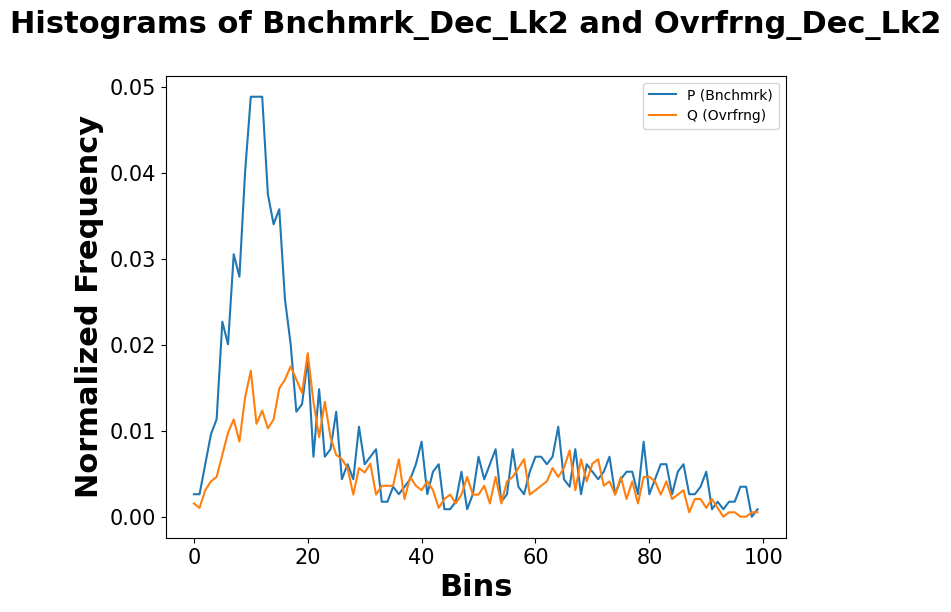


KL(P || Q) = ∑(P(x) * log(P(x) / Q(x)))
KL Divergence: 0.770105507643642

spike_data_benchmark shape:  (1024,)


<ipython-input-27-5f35114e6db9>:76: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(spike_data_benchmark, label='Bnchmrk', shade=True)
<ipython-input-27-5f35114e6db9>:79: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(spike_data_overfiring, label='Ovrfrng', shade=True)


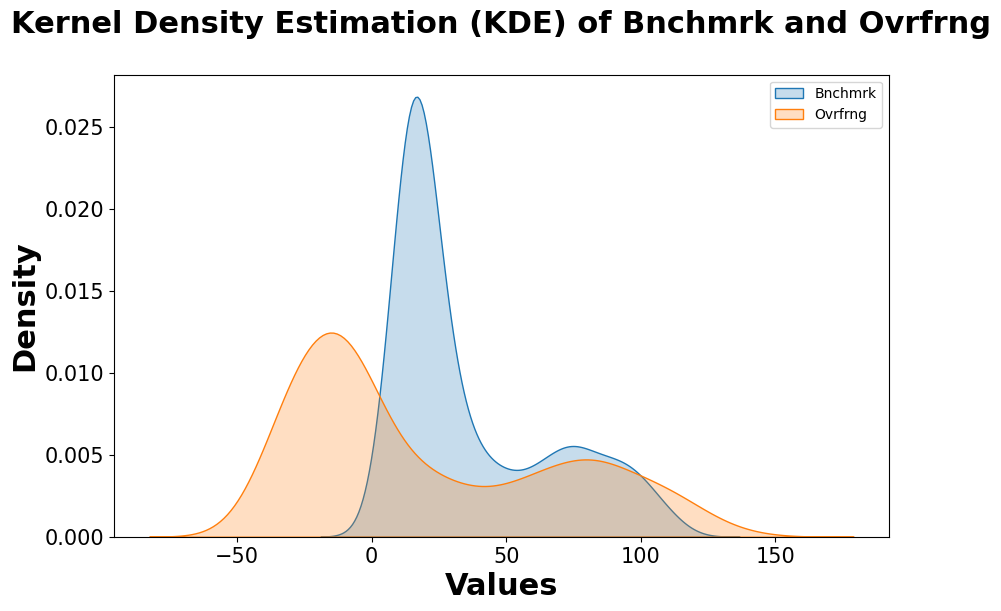

In [ ]:
font_size = 15
font = {'weight': 'bold', 'size': 22}


# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming you have already loaded Ovrfrng_Enc_Syn1 and Bnchmrk_Enc_Syn1

# # Compute the probability distributions
# prob_Ovrfrng = Ovrfrng_Dec_Lk2 / np.sum(Ovrfrng_Dec_Lk2)
# prob_Bnchmrk = Bnchmrk_Dec_Lk2 / np.sum(Bnchmrk_Dec_Lk2)

# # Calculate KL divergence
# kl_divergence = np.sum(prob_Ovrfrng * np.log(prob_Ovrfrng / prob_Bnchmrk))

# # Visualize the KL divergence
# plt.figure(figsize=(8, 6))
# plt.imshow(kl_divergence, cmap='viridis', origin='lower')
# plt.colorbar(label='KL Divergence')
# plt.title('KL Divergence between Ovrfrng and Bnchmrk')
# plt.xlabel('Dimension')
# plt.ylabel('Dimension')
# plt.show()

# # Print the KL divergence value
# print(f"KL Divergence: {kl_divergence}")



import numpy as np
import matplotlib.pyplot as plt




# Calculate histograms with smoothing
epsilon = 1e-10  # Small epsilon value for smoothing
hist_p = np.histogram(Bnchmrk_Dec_Lk2, bins=100, density=True)[0] + epsilon
hist_q = np.histogram(Ovrfrng_Dec_Lk2, bins=100, density=True)[0] + epsilon

print("Bnchmrk_Dec_Lk2 shape: ", Bnchmrk_Dec_Lk2.shape)

# Visualize the KL divergence
plt.figure(figsize=(8, 6))
plt.plot(hist_p, label='P (Bnchmrk)')
plt.plot(hist_q, label='Q (Ovrfrng)')
plt.xlabel('Bins', fontdict=font)
plt.ylabel('Normalized Frequency', fontdict=font)
plt.title('Histograms of Bnchmrk_Dec_Lk2 and Ovrfrng_Dec_Lk2\n', fontdict=font)
plt.tick_params(labelsize=font_size)
plt.legend()
plt.show()

# Calculate the KL divergence
kl_divergence = np.sum(hist_p * np.log(hist_p / hist_q))
print ('\nKL(P || Q) = ∑(P(x) * log(P(x) / Q(x)))')
print(f"KL Divergence: {kl_divergence}\n")



# -------------------------------------- KDE -----------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming spike_data contains both Bnchmrk_Dec_Lk2 and Ovrfrng_Dec_Lk2
spike_data_benchmark = Bnchmrk_Dec_Lk2.flatten()
spike_data_overfiring = Ovrfrng_Dec_Lk2.flatten()
print("spike_data_benchmark shape: " , spike_data_benchmark.shape)

# Create KDE plots for both states
plt.figure(figsize=(10, 6))

# KDE plot for Bnchmrk
sns.kdeplot(spike_data_benchmark, label='Bnchmrk', shade=True)

# KDE plot for Ovrfrng
sns.kdeplot(spike_data_overfiring, label='Ovrfrng', shade=True)

plt.xlabel('Values', fontdict=font)
plt.ylabel('Density', fontdict=font)
plt.title('Kernel Density Estimation (KDE) of Bnchmrk and Ovrfrng\n', fontdict=font)
plt.tick_params(labelsize=font_size)
plt.legend()
plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming spike_data contains both Bnchmrk_Dec_Lk2 and Ovrfrng_Dec_Lk2
spike_data_benchmark = Bnchmrk_Dec_Lk2
spike_data_overfiring = Ovrfrng_Dec_Lk2

# Calculate the probability distribution for each neuron for benchmark data
probabilities_benchmark = np.mean(spike_data_benchmark, axis=(0, 1, 2))

# Calculate the probability distribution for each neuron for overfiring data
probabilities_overfiring = np.mean(spike_data_overfiring, axis=(0, 1, 2))

# Check if any of the probability arrays are constant (zero variance)
if np.var(probabilities_benchmark) == 0 or np.var(probabilities_overfiring) == 0:
    print("Zero variance in probability distribution. Cannot compute entropy.")
else:
    # Compute the entropy for both benchmark and overfiring data
    def entropy(p):
        return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

    entropies_benchmark = entropy(probabilities_benchmark)
    entropies_overfiring = entropy(probabilities_overfiring)

    # Visualize the entropy values using KDE plots
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    sns.kdeplot(entropies_benchmark, shade=True, color='b')
    plt.xlabel('Entropy')
    plt.ylabel('Probability Density')
    plt.title('Entropy Distribution (Benchmark)')

    plt.subplot(2, 1, 2)
    sns.kdeplot(entropies_overfiring, shade=True, color='g')
    plt.xlabel('Entropy')
    plt.ylabel('Probability Density')
    plt.title('Entropy Distribution (Overfiring)')

    plt.tight_layout()
    plt.show()


AxisError: ignored